In [2]:
import pandas as pd
#import bamboolib
import os
import datetime
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator
#import plotly.express as px
#import plotly.graph_objects as go
import seaborn as sns
import scipy
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from IPython.core.display import display, HTML
import re

/var/folders/bx/gl47n30d0zbbbqzp9zh3kcrr0000gn/T/ipykernel_18176/1884286207.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Analyse des segments

In [16]:
aymeric =  "/home/aymeric/python-scripts/anses_medialab/datas/" #aymeric
jp = '~/Dropbox/Mac/Desktop/CRD Anses/all3/' # Jean Philippe


path_base = aymeric
path_base = jp


file_segmentation = f"{path_base}segmentation_common_freq.csv"

index=f"{path_base}index_alldefault_nameexhaustive_aymeric.csv"
index='/Users/jpcointet/Dropbox/Mac/Desktop/CRD Anses/code/indexation_results/index_alldefault_nameexhaustive_aymeric.csv'


all_corpus = f"{path_base}all_corpus_seg_with_sdhi_PI.csv"

text_qualification = f"{path_base}text_qualification.csv"

#twittos = f"{path_base}tweets_pesticides/500_first_twittos_on_pesticides.csv"

data_file = path_base+'fb_tw_med_data.csv.gz'#,line_terminator='\n',index=False)


In [13]:
list_base = ["index", "all_corpus", "text_qualification"]
which_base = list_base[0]

In [14]:
dfseg0 = pd.read_csv(file_segmentation, sep = "\t")
if which_base == "all_corpus":
    df0 = pd.read_csv(all_corpus, sep = "\t")
elif which_base == "text_qualification":
    df0 = pd.read_csv(text_qualification, sep = "\t")
else:
    df_index = pd.read_csv(index, sep = "\t")

    df_index['date'] = pd.to_datetime(df_index['date'], infer_datetime_format=True)
    df_index['yearmonth']=(df_index['date'].dt.strftime('%Y-%m'))
    df_index['date'] = df_index['date'].dt.date
    
    segment = dfseg0[["yearmonth", "segm", "origin"]]
    df0 = df_index.merge(segment, how = "inner", on = ["origin", "yearmonth"])
    df0["start_segment"] = df0.groupby(['origin','segm'])["date"].transform('min')
    df0["end_segment"] = df0.groupby(['origin','segm'])["date"].transform('max')

In [17]:
dft = pd.read_csv(data_file)

In [18]:
# Step: Rename column
dft = dft.rename(columns={'id': 'doc_id'})

dft['date'] = pd.to_datetime(dft['date'], infer_datetime_format=True)

dft['yearmonth']=(dft['date'].dt.strftime('%Y-%m'))
dft['date'] = dft['date'].dt.date
    
segment = dfseg0[["yearmonth", "segm", "origin"]]
dft0 = dft.merge(segment, how = "inner", on = ["origin", "yearmonth"])
dft0["start_segment"] = dft0.groupby(['origin','segm'])["date"].transform('min')
dft0["end_segment"] = dft0.groupby(['origin','segm'])["date"].transform('max')



In [19]:
df0

,term,doc_id,sent_id,origin,source,date,yearmonth,segm,start_segment,end_segment
0,agriculteur,1128193072427409409,0,twitter,cchris,2019-05-14,2019-05,5.0,2017-09-01,2019-05-31
1,pesticides,1128193072427409409,0,twitter,cchris,2019-05-14,2019-05,5.0,2017-09-01,2019-05-31
2,travail,1128193072427409409,0,twitter,cchris,2019-05-14,2019-05,5.0,2017-09-01,2019-05-31
3,glyphosate,1127799058041647106,0,twitter,slimane,2019-05-13,2019-05,5.0,2017-09-01,2019-05-31
4,parlementaires,1127799058041647106,0,twitter,slimane,2019-05-13,2019-05,5.0,2017-09-01,2019-05-31
...,...,...,...,...,...,...,...,...,...,...
7832285,scientifiques,https://www.lemonde.fr/planete/article/2012/07...,71,media,Le Monde,2012-07-09,2012-07,4.0,2011-11-03,2012-10-31
7832286,travail,https://www.lemonde.fr/planete/article/2012/07...,71,media,Le Monde,2012-07-09,2012-07,4.0,2011-11-03,2012-10-31
7832287,travail,https://www.lemonde.fr/planete/article/2012/07...,71,media,Le Monde,2012-07-09,2012-07,4.0,2011-11-03,2012-10-31
7832288,syngenta,https://www.lemonde.fr/planete/article/2012/07...,72,media,Le Monde,2012-07-09,2012-07,4.0,2011-11-03,2012-10-31


## Facebook

In [22]:
def filter_data(data, domain, segment):
    print(domain)
    dfseg = data[0]
    dfseg1 = dfseg.loc[(dfseg["origin"] == domain) & (dfseg["segm"] == segment)]
    
    df = data[1]
    df1 = df.loc[(df["origin"] == domain) & (df["segm"] == segment)]
    
    dft = data[2]
    dft1 = dft.loc[(dft["origin"] == domain) & (dft["segm"] == segment)]
    dft1['doc_id'] = dft1['doc_id'].astype('string')
    
    specific_terms = [x.strip() for x in dfseg1["top20_term_chi2_True"].iloc[0].split(",")]

    print(specific_terms)
    df1.loc[df1["term"].isin(specific_terms) == True, "in_top20_term"] = 1
    df1.loc[df1["term"].isin(specific_terms) == False, "in_top20_term"] = 0
    # Step: Change data type of Subject to String/Text
    #df1['Subject'] = df1['Subject'].astype('string')

    # Step: Keep rows where Subject is missing
    #df1 = df1.loc[df1['Subject'].isna()]
    
    df2 = df1.drop_duplicates(subset = ["doc_id", "term"]).groupby(['doc_id', 'source', "date"]).agg(sum_of_top20_term =('in_top20_term', 'sum')).reset_index()

    df2 = df2.merge(dft1[["doc_id", "text"]], how = "inner", on = ["doc_id"])
    
    return dfseg1, df1, dft1, df2, specific_terms

In [23]:
domains = ["facebook", "twitter", "media"]
segment = 1
domain = domains[0]

list_df = [dfseg0, df0, dft0]
dfseg1, df1, dft1, df2, specific_terms = filter_data(list_df, domain = domain, segment = segment)

facebook
['santé des français', 'semences transgéniques', 'confédération paysanne', 'agriculteur', 'ogm', 'lasso', 'paysan', 'monsanto', 'vérité', 'syndrome', 'pesticides', "conseil d'état", 'libertés', 'victimes', 'santé', 'autorité', 'maladie', 'omerta', 'nappes phréatiques', 'monde']


/var/folders/bx/gl47n30d0zbbbqzp9zh3kcrr0000gn/T/ipykernel_18176/1080972600.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft1['doc_id'] = dft1['doc_id'].astype('string')
/var/folders/bx/gl47n30d0zbbbqzp9zh3kcrr0000gn/T/ipykernel_18176/1080972600.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[df1["term"].isin(specific_terms) == True, "in_top20_term"] = 1


In [24]:
moyenne = np.mean(df2["sum_of_top20_term"]) 
df3 = df2.loc[df2["sum_of_top20_term"] >= 2 ]
df3 = df3.sort_values(by=['date'], ascending=[True])

#df3 = df3.drop_duplicates(subset = "text")

In [98]:
df11

,term,doc_id,count_doc
1,abeilles,412279,1
2,abeilles,412280,1
3,abeilles,412282,2
4,abeilles,412284,2
5,abeilles,412285,2
...,...,...,...
7957,travail,413616,1
7958,travail,413660,1
7959,travail,413716,1
7960,travail,413717,2


In [103]:
df11 = df1.groupby(['term', 'doc_id']).agg(count_doc = ("doc_id", "count")).reset_index()

freq_words=df11.groupby('term')['count_doc'].sum().reset_index().sort_values(by='count_doc', ascending=False)
top50 = freq_words.term[:30].values

df11=df11.merge(df1[['term','in_top20_term']],on='term')
#df11 = df1.loc[df1["in_top20_term"] ==  1]
df11=df11[(df11['term'].isin(top50)) | (df11["in_top20_term"] ==  1)]



In [104]:
import math



#df11 = df1
#df11 = df11.groupby(['term', 'doc_id']).agg(count_doc = ("doc_id", "count")).reset_index()


#t = pd.pivot_table(df11, index = "doc_id", columns = "term", values = "count_term", fill_value = 0)


#rho_segment, pval_segment = scipy.stats.spearmanr(t,axis=1)
#rho_terms, pval_terms = scipy.stats.spearmanr(t,axis=0)

dico_freq={}
for l in df11.groupby('term'):
    term=l[0]
    #print (term)
    dico_freq[term]={}
    for d in l[1].groupby('doc_id'):
        #print (d[0],d[1]['count_doc'].values[0])
        dico_freq[term][d[0]]=d[1]['count_doc'].values[0]

for t in dico_freq:
    N=sum(dico_freq[t].values())
    for d in dico_freq[t]:
        dico_freq[t][d]=dico_freq[t][d]/N
    
                
squared={}
spec_words=list(dico_freq.keys())
for w1 in spec_words:
    s=0
    for d1 in dico_freq[w1]:
        #if d1 in spec_words[w2]:
        s += dico_freq[w1][d1] * dico_freq[w1].get(d1,0)
    squared[w1]=s

similarity=[]
spec_words=list(dico_freq.keys())
for w1 in spec_words:
    sim=[]
    for w2 in spec_words:
        s=0
        for d1 in dico_freq[w1]:
            #if d1 in spec_words[w2]:
            s += dico_freq[w1][d1] * dico_freq[w2].get(d1,0)
        sim.append(s/math.sqrt(squared[w1]*squared[w2]))
    similarity.append(sim)

#similarity

In [105]:
similarity

[[1.0,
  0.0243381548571406,
  0.012474686476085338,
  0.057214419922486735,
  0.022731397155381965,
  0.010057619197268056,
  0.0071737483538543865,
  0.04662781419901753,
  0.0,
  0.009338863578008763,
  0.1511572177607063,
  0.25037380874205145,
  0.04369139980448015,
  0.0030690047271290924,
  0.14191488192315257,
  0.0019538331901481415,
  0.0,
  0.0,
  0.021115487718274487,
  0.05454559541752556,
  0.1368229331140571,
  0.10391328106475832,
  0.06026522383037987,
  0.05806769150949455,
  0.0,
  0.014312216423292582,
  0.26610017711152023,
  0.06196313489388699,
  0.016454636677740202,
  0.045759881536972004,
  0.0597303430860246,
  0.02797216928427846,
  0.0,
  0.0,
  0.0,
  0.020161437971701245,
  0.020040874966625565,
  0.05632017953621903,
  0.008129325710025144,
  0.0,
  0.2847264195729079],
 [0.0243381548571406,
  1.0,
  0.04064590271099227,
  0.14712563207588336,
  0.022179905132936464,
  0.15067978545321817,
  0.1323381590247388,
  0.08992680488993851,
  0.0563436169819011

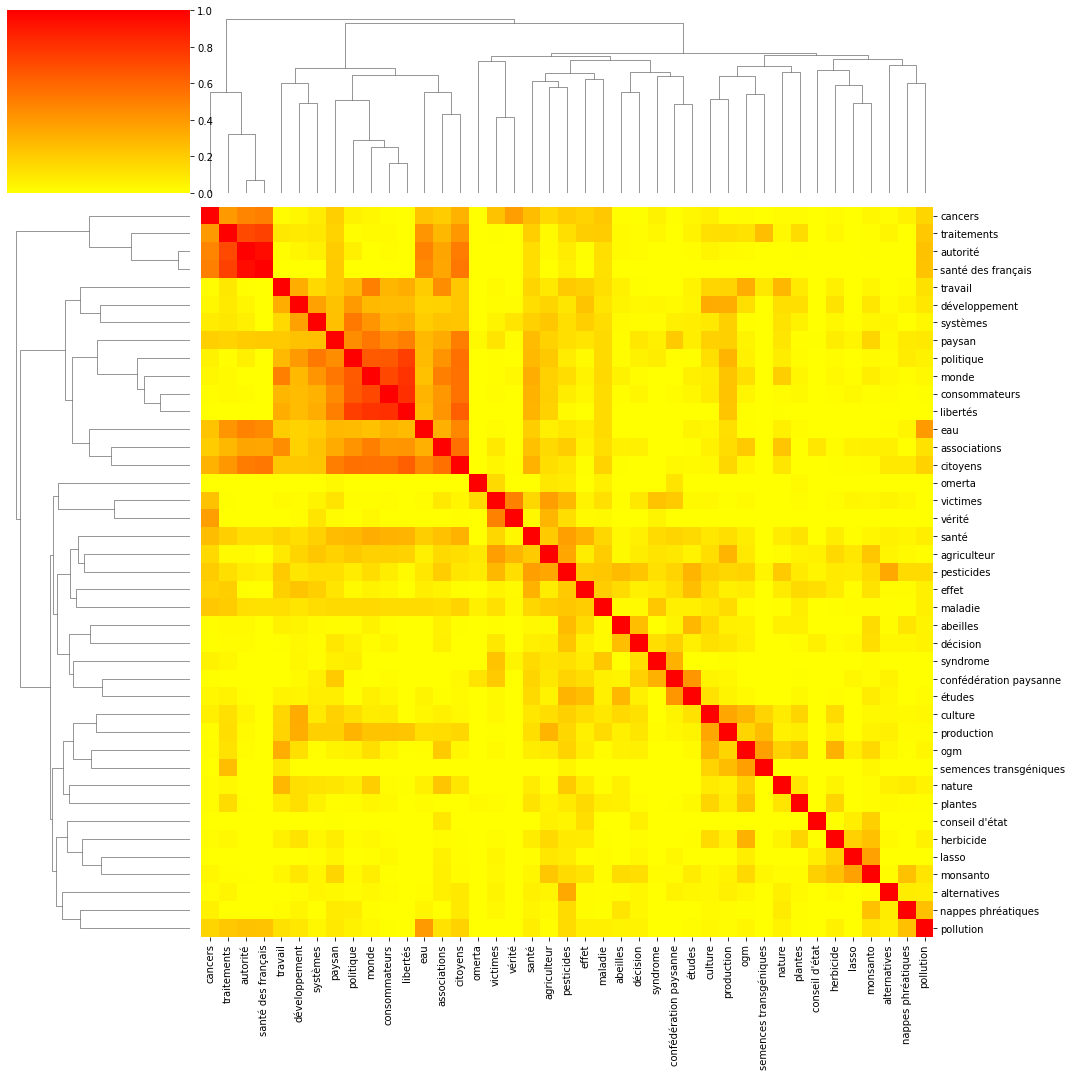

In [106]:
from matplotlib import pyplot as plt


cmap_reversed = plt.cm.get_cmap('autumn_r')
#sns.clustermap(rho_terms)
ax=sns.clustermap(similarity,figsize=(15,15), cmap = cmap_reversed)#,labels=range(14))
new_labels=[]
labels_list=list(spec_words)
for l in ax.ax_heatmap.axes.get_xticklabels():
    l.set_text(labels_list[int(l.get_text())])
    new_labels.append(l)
ax.ax_heatmap.axes.set_yticklabels(new_labels,rotation=0)
ax.ax_heatmap.axes.set_xticklabels(new_labels,rotation = 90)
#ax.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
#ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.tight_layout()

In [50]:
nombre_texts = len(df3["text"])
start_segment = df1["start_segment"].iloc[1]#.strftime("%Y-%m-%d")
end_segment = df1["end_segment"].iloc[1]#.strftime("%Y-%m-%d")

for i, text in enumerate(df3["text"]):
    doc_id = df3["doc_id"].iloc[i]
    list_term = [x for x in df1["term"].loc[(df1["doc_id"] == doc_id)].unique()]
    term_to_search = ["lasso", 'ogm', 'roundup', 'monsanto']
    nb_term_to_search = [x for x in term_to_search if x in list_term]
    
    if len(nb_term_to_search) >= 0:
        #Thematique = "Tous contre Monsanto"
        #df1.loc[(df1["doc_id"].str.contains(doc_id) == True), "Subject"] = Thematique
        list_top20_term = [x for x in df1["term"].loc[(df1["doc_id"] == doc_id) & (df1["in_top20_term"] == 1)].unique()]
        list_top20_term_absent = set(specific_terms) - set(list_top20_term)
        date = df3["date"].iloc[i]#.strftime("%Y-%m-%d")
        auteur = df3["source"].iloc[i]
        display(HTML(f"<h2 style='text-align:center;'> Texte {doc_id} ({i+1} sur {nombre_texts})</h2>"))
        display(HTML(f"<strong>Segment :</strong> {segment} ({start_segment} ; {end_segment})"))
        display(HTML(f"<strong>Date :</strong> {date}"))
        display(HTML(f"<strong>Auteur :</strong> {auteur} \n"))
        print(f"Termes indexés : {list_term} \n")
        print(f"Termes spécifiques présents : {list_top20_term} \n")
        print(f"Termes spécifiques absents : {list_top20_term_absent} \n")
        #display(HTML(f"<strong>Thématique :</strong> {Thematique} \n"))
        try:
            for j, term in enumerate(list_term):
                if term not in list_top20_term:
                    text = re.sub(term, f'<mark style="background-color:yellow">{term}</mark>', text, flags=re.I)  
                else:
                    text = re.sub(term, f'<mark style="background-color:pink">{term}</mark>', text, flags=re.I)  
            display(HTML(f'{text}'))
        except:
            print(f"{text} \n")
    else:
        pass
   

Termes indexés : ['antilles', 'études', 'monde', 'pesticides'] 

Termes spécifiques présents : ['monde', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['alimentation', 'santé', 'pesticides', 'effet', 'cancers', 'maladie', 'produits chimiques', 'bisphénol', 'bisphénol a', 'grossesse', 'chercheuse'] 

Termes spécifiques présents : ['santé', 'pesticides', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['antilles', 'études', 'monde', 'pesticides'] 

Termes spécifiques présents : ['monde', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['antilles', 'études', 'monde', 'pesticides'] 

Termes spécifiques présents : ['monde', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['ami', 'commission', 'commission environnement', 'pesticides', 'production', 'régions', 'mouvements', 'génération', 'générations futures', 'futures', 'déchets', 'abeilles', 'femmes', 'écologiste', 'scientifiques', 'politique', 'médecin', 'agriculteur', 'alternatives', 'débat', 'espace', 'espaces verts', 'santé', 'nappes', 'nappes phréatiques', 'alternatives aux pesticides', 'pratiques', 'décision'] 

Termes spécifiques présents : ['pesticides', 'agriculteur', 'santé', 'nappes phréatiques'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['aliments', 'santé', 'produits chimiques', 'pesticides', 'cancers', 'animal', 'maladie', 'maladies cardiovasculaires', 'mortalité', 'milieu'] 

Termes spécifiques présents : ['santé', 'pesticides', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['sécurité sanitaire', 'santé', 'sécurité des aliments', 'aliments', 'ong', 'pesticides', 'travail', 'scientifiques', 'problème', 'avis', 'molécules', 'chimie'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'victimes', 'victimes de pesticides', 'paris'] 

Termes spécifiques présents : ['pesticides', 'santé', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['ami', 'commission', 'commission environnement', 'pesticides', 'production', 'régions', 'mouvements', 'génération', 'générations futures', 'futures', 'déchets', 'abeilles', 'femmes', 'écologiste', 'scientifiques', 'politique', 'médecin', 'agriculteur', 'alternatives', 'débat', 'espace', 'espaces verts', 'santé', 'nappes', 'nappes phréatiques', 'alternatives aux pesticides', 'pratiques', 'décision'] 

Termes spécifiques présents : ['pesticides', 'agriculteur', 'santé', 'nappes phréatiques'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monde', 'pesticides'] 

Termes spécifiques présents : ['monde', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'citoyens', 'monde', 'régions'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'traitements', 'traitements phytosanitaires', 'ravageurs', 'culture', 'recherche', 'santé', 'production', 'serres'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['ruches', 'apiculteur', 'pesticides', 'procès', 'cour', "cour d'appel", 'justice', 'mortalité', 'abeilles', 'disparition', 'culture', 'cultures de maïs', 'maïs', 'ogm', 'miel', 'plainte'] 

Termes spécifiques présents : ['pesticides', 'ogm'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['ruches', 'apiculteur', 'pesticides', 'procès', 'cour', "cour d'appel", 'justice', 'mortalité', 'abeilles', 'disparition', 'culture', 'cultures de maïs', 'maïs', 'ogm', 'miel', 'plainte'] 

Termes spécifiques présents : ['pesticides', 'ogm'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['nature', 'progrès', 'pesticides', 'ogm'] 

Termes spécifiques présents : ['pesticides', 'ogm'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'expositions', 'sciences'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'ogm', 'algue'] 

Termes spécifiques présents : ['pesticides', 'ogm'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['scientifiques', 'pesticides', 'insectes', 'ravageurs', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['antilles', 'études', 'monde', 'pesticides'] 

Termes spécifiques présents : ['monde', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['santé', 'recherche', 'ogm', 'glyphosate', 'plantes', 'maladie', 'systèmes', 'brésil'] 

Termes spécifiques présents : ['santé', 'ogm', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'pesticides', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['guadeloupe', 'antilles', 'études', 'monde', 'pesticides'] 

Termes spécifiques présents : ['monde', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['etat', 'sciences', 'chercheuse', 'cancers', 'thyroïde', 'pesticides', 'citoyens', 'monde'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'agriculteur', 'systèmes', 'production', 'énergie', 'culture'] 

Termes spécifiques présents : ['pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['agriculteur', 'produits bio', 'pesticides', 'produits chimiques', 'troubles', 'santé', 'procès'] 

Termes spécifiques présents : ['agriculteur', 'pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monsanto', 'collectifs', 'combat', 'pesticides', 'herbicide'] 

Termes spécifiques présents : ['monsanto', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monsanto', 'article', 'monde', 'chimie'] 

Termes spécifiques présents : ['monsanto', 'monde'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'pesticides', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['politique', 'santé', 'origine', 'loi', 'syndrome', 'maladie', 'victimes', 'inde', 'alzheimer', 'conflit', 'déchets', 'pesticides', 'bisphénol', 'bisphénol a', 'résidus', 'résidus chimiques', 'cancers'] 

Termes spécifiques présents : ['santé', 'syndrome', 'maladie', 'victimes', 'pesticides'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'monde', 'nappes phréatiques', 'paysan', "conseil d'état", 'autorité', 'santé des français'} 



Termes indexés : ['pesticides', 'agriculteur', 'santé', 'consommateurs'] 

Termes spécifiques présents : ['pesticides', 'agriculteur', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'ogm', 'effet', 'santé'] 

Termes spécifiques présents : ['pesticides', 'ogm', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['maïs', 'campagne', 'culture', 'abeilles', 'pesticides', 'monsanto', 'ami', 'ogm', 'politique', 'collectifs', 'associations', 'greenpeace'] 

Termes spécifiques présents : ['pesticides', 'monsanto', 'ogm'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['additifs', 'substances', 'aliments', 'traitements', 'transport', 'effet', 'santé', 'monde', 'problème', 'recherche', 'cancers', 'pesticides', 'troubles', 'sucre', 'allemagne'] 

Termes spécifiques présents : ['santé', 'monde', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['ogm', 'pesticides', 'monsanto', 'article', 'monde'] 

Termes spécifiques présents : ['ogm', 'pesticides', 'monsanto', 'monde'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'agriculteur', 'europe', 'résidus', 'résidus de pesticides', 'limite'] 

Termes spécifiques présents : ['pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['paul françois', 'pesticides', 'combat', 'monde'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['graines', 'arrêté', 'paysan', 'culture', 'victimes', 'effet', 'maïs', 'travail', 'récolte', 'herbicide', 'femmes', 'monde'] 

Termes spécifiques présents : ['paysan', 'victimes', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'pesticides', 'santé des français', 'agriculteur', 'nappes phréatiques', 'maladie'} 



Termes indexés : ['monde', 'inde', 'problème', 'pollution', 'effet', 'eau', 'maladie', 'pesticides'] 

Termes spécifiques présents : ['monde', 'maladie', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['politique', 'combat', 'progrès', 'loi', 'génération', 'production', 'transport', 'renouvellement', 'paysan', 'maïs', 'monde', 'population'] 

Termes spécifiques présents : ['paysan', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'pesticides', 'santé des français', 'agriculteur', 'nappes phréatiques', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'agriculteur', 'systèmes', 'production', 'énergie'] 

Termes spécifiques présents : ['pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['consommateurs', 'lobbies', 'ogm', 'abeilles', 'miel', 'apiculteur', 'pesticides', 'ruches', 'plantes'] 

Termes spécifiques présents : ['ogm', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'agriculteur', 'débat'] 

Termes spécifiques présents : ['pesticides', 'santé', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['consommateurs', 'pesticides', 'monde'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['résistances', 'paysan', 'maïs', 'pesticides', 'arrêté', 'abeilles'] 

Termes spécifiques présents : ['paysan', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'victimes', 'maladie'} 



Termes indexés : ['écologie', 'pesticides', 'ogm', 'développement', 'nature', 'paysan', 'agroalimentaire', 'pollution', 'monde', 'santé'] 

Termes spécifiques présents : ['pesticides', 'ogm', 'paysan', 'monde', 'santé'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'santé des français', 'libertés', 'omerta', 'vérité', 'agriculteur', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes', 'autorité', 'maladie'} 



Termes indexés : ['pesticides', 'citoyens', 'nature', 'nature environnement', 'ogm'] 

Termes spécifiques présents : ['pesticides', 'ogm'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['ogm', 'pesticides', 'production', 'produits agricoles', 'agriculteur', 'élevage', 'régions'] 

Termes spécifiques présents : ['ogm', 'pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['conclusion', 'systèmes', 'système endocrinien', 'substances', 'perturbateurs', 'perturbateurs endocriniens', 'chercheuse', 'travail', 'effet', 'produits chimiques', 'femmes', 'femmes enceintes', 'traitements', 'bisphénol', 'bisphénol a', 'phtalates', 'études', 'santé', 'cancers', 'développement', 'population', 'pesticides', 'grossesse', 'maladie', 'maladies cardiovasculaires', 'adultes', 'expositions'] 

Termes spécifiques présents : ['santé', 'pesticides', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['santé', 'pesticides', 'nature', 'espace', 'espaces verts'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'récolte', 'agriculteur', 'animal', 'animal domestique', 'plantes'] 

Termes spécifiques présents : ['pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['alternatives', 'alternatives aux pesticides', 'pesticides', 'pollution', 'monde'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['agriculteur', 'politique', 'pesticides', 'campagne'] 

Termes spécifiques présents : ['agriculteur', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['consommateurs', 'pesticides', 'monde', 'molécules'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['malbouffe', 'ogm', 'pesticides', 'ravageurs', 'scientifiques', 'paysan'] 

Termes spécifiques présents : ['ogm', 'pesticides', 'paysan'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'paysan', 'monde'] 

Termes spécifiques présents : ['pesticides', 'paysan', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'victimes', 'maladie'} 



Termes indexés : ['monde', 'collectifs', 'génération', 'générations futures', 'futures', 'victimes', 'victimes de pesticides', 'pesticides'] 

Termes spécifiques présents : ['monde', 'victimes', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['confédération paysanne', 'victimes', 'victimes de pesticides', 'pesticides', 'paul françois', 'paysan', 'citoyens', 'lobbies', 'problème', 'santé'] 

Termes spécifiques présents : ['confédération paysanne', 'victimes', 'pesticides', 'paysan', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'semences transgéniques', 'santé des français', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'autorité', 'maladie'} 



Termes indexés : ['victimes', 'victimes de pesticides', 'pesticides'] 

Termes spécifiques présents : ['victimes', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['pesticides', 'vins', 'agriculteur', 'santé', 'plantes', 'lobbies', 'travail', 'nappes', 'nappes phréatiques'] 

Termes spécifiques présents : ['pesticides', 'agriculteur', 'santé', 'nappes phréatiques'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['victimes', 'maladie', 'pesticides', 'journaliste'] 

Termes spécifiques présents : ['victimes', 'maladie', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan'} 



Termes indexés : ['paysan', 'monde', 'pesticides', 'pac', 'agriculteur', 'loi'] 

Termes spécifiques présents : ['paysan', 'monde', 'pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'victimes', 'maladie', 'agriculteur', 'plantes', 'santé', 'paysan'] 

Termes spécifiques présents : ['pesticides', 'victimes', 'maladie', 'agriculteur', 'santé', 'paysan'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'autorité', 'santé des français'} 



Termes indexés : ['pesticides', 'paysan', 'associations', 'consommateurs', 'pollution', 'eau', 'abeilles', 'insectes', 'médecin', 'cancers'] 

Termes spécifiques présents : ['pesticides', 'paysan'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'victimes', 'maladie'} 



Termes indexés : ['victimes', 'militante', 'associations', 'décision', 'pesticides'] 

Termes spécifiques présents : ['victimes', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['victimes', 'victimes de pesticides', 'pesticides'] 

Termes spécifiques présents : ['victimes', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['monsanto', 'ogm', 'pesticides'] 

Termes spécifiques présents : ['monsanto', 'ogm', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monsanto', 'ogm', 'pesticides'] 

Termes spécifiques présents : ['monsanto', 'ogm', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['effet', 'agriculteur', 'pesticides'] 

Termes spécifiques présents : ['agriculteur', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'agriculteur', 'campagne'] 

Termes spécifiques présents : ['pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monde', 'malbouffe', 'pesticides', 'population'] 

Termes spécifiques présents : ['monde', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['victimes', 'pesticides', 'maladie', 'cancers'] 

Termes spécifiques présents : ['victimes', 'pesticides', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan'} 



Termes indexés : ['pesticides', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['paris', 'abeilles', 'agriculteur', 'victimes', 'victimes de pesticides', 'pesticides', 'apiculteur', 'ogm'] 

Termes spécifiques présents : ['agriculteur', 'victimes', 'pesticides', 'ogm'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['ogm', 'monsanto', 'citoyens', 'pesticides'] 

Termes spécifiques présents : ['ogm', 'monsanto', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['ogm', 'monsanto', 'citoyens', 'pesticides'] 

Termes spécifiques présents : ['ogm', 'monsanto', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['ogm', 'monsanto', 'citoyens', 'pesticides'] 

Termes spécifiques présents : ['ogm', 'monsanto', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'agriculteur', 'omerta', 'victimes', 'maladie', 'confédération paysanne'] 

Termes spécifiques présents : ['pesticides', 'agriculteur', 'omerta', 'victimes', 'maladie', 'confédération paysanne'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'vérité', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'santé', 'paysan', 'autorité', 'santé des français'} 



Termes indexés : ['victimes', 'omerta', 'médecin', 'agriculteur', 'paysan', 'pesticides'] 

Termes spécifiques présents : ['victimes', 'omerta', 'agriculteur', 'paysan', 'pesticides'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'santé des français', 'libertés', 'vérité', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'santé', 'autorité', 'maladie'} 



Termes indexés : ['pesticides', 'agriculteur', 'omerta', 'victimes', 'maladie', 'plantes', 'confédération paysanne'] 

Termes spécifiques présents : ['pesticides', 'agriculteur', 'omerta', 'victimes', 'maladie', 'confédération paysanne'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'vérité', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'santé', 'paysan', 'autorité', 'santé des français'} 



Termes indexés : ['pesticides', 'victimes', 'maladie', 'agriculteur', 'plantes'] 

Termes spécifiques présents : ['pesticides', 'victimes', 'maladie', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan'} 



Termes indexés : ['expositions', 'interdiction', 'europe', 'pesticides', 'santé', 'santé publique'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['recherche', 'scientifiques', 'travail', 'effet', 'ogm', 'pesticides', 'santé'] 

Termes spécifiques présents : ['ogm', 'pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'herbicide', 'animal', 'ogm'] 

Termes spécifiques présents : ['pesticides', 'ogm'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'concentration'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'agriculteur', 'omerta', 'maladie', 'paris'] 

Termes spécifiques présents : ['pesticides', 'agriculteur', 'omerta', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['pesticides', 'paysan', 'mouvements'] 

Termes spécifiques présents : ['pesticides', 'paysan'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'concentration'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'paysan'] 

Termes spécifiques présents : ['pesticides', 'paysan'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'victimes', 'maladie'} 



Termes indexés : ['autorité', 'santé', 'santé des français', 'citoyens', 'pesticides', 'traitements', 'cancers', 'dérogation', 'eau'] 

Termes spécifiques présents : ['autorité', 'santé', 'santé des français', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'monde', 'confédération paysanne', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'concentration'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'paysan', 'alimentation', 'article'] 

Termes spécifiques présents : ['pesticides', 'paysan'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'produits chimiques', 'produits bio', 'santé', 'planète'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monde', 'loi', 'limite', 'systèmes', 'femmes', 'planète', 'concentration', 'pesticides', 'sciences', 'vérité', 'développement', 'animal', 'connaissances'] 

Termes spécifiques présents : ['monde', 'pesticides', 'vérité'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'autorité', 'santé', 'santé des français', 'citoyens', 'pesticides', 'traitements', 'cancers', 'dérogation', 'eau', 'maladie', 'scientifiques', 'réglementation', 'résidus', 'population', 'molécules', 'pollution', 'mouvements', 'paysan'] 

Termes spécifiques présents : ['autorité', 'santé', 'santé des français', 'pesticides', 'maladie', 'paysan'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'autorité', 'santé', 'santé des français', 'citoyens', 'pesticides', 'traitements', 'cancers', 'dérogation', 'eau', 'maladie', 'scientifiques', 'réglementation', 'résidus', 'population', 'molécules', 'pollution', 'mouvements', 'paysan'] 

Termes spécifiques présents : ['autorité', 'santé', 'santé des français', 'pesticides', 'maladie', 'paysan'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'autorité', 'santé', 'santé des français', 'citoyens', 'pesticides', 'traitements', 'cancers', 'dérogation', 'eau', 'maladie', 'scientifiques', 'réglementation', 'résidus', 'population', 'molécules', 'pollution', 'mouvements', 'paysan'] 

Termes spécifiques présents : ['autorité', 'santé', 'santé des français', 'pesticides', 'maladie', 'paysan'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'autorité', 'santé', 'santé des français', 'citoyens', 'pesticides', 'traitements', 'cancers', 'dérogation', 'eau', 'maladie', 'scientifiques', 'réglementation', 'résidus', 'population', 'molécules', 'pollution', 'mouvements', 'paysan'] 

Termes spécifiques présents : ['autorité', 'santé', 'santé des français', 'pesticides', 'maladie', 'paysan'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'autorité', 'santé', 'santé des français', 'citoyens', 'pesticides', 'traitements', 'cancers', 'dérogation', 'eau', 'maladie', 'scientifiques', 'réglementation', 'résidus', 'population', 'molécules', 'pollution', 'mouvements', 'paysan'] 

Termes spécifiques présents : ['autorité', 'santé', 'santé des français', 'pesticides', 'maladie', 'paysan'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'autorité', 'santé', 'santé des français', 'citoyens', 'pesticides', 'traitements', 'cancers', 'dérogation', 'eau', 'maladie', 'scientifiques', 'réglementation', 'résidus', 'population', 'molécules', 'pollution', 'mouvements', 'paysan'] 

Termes spécifiques présents : ['autorité', 'santé', 'santé des français', 'pesticides', 'maladie', 'paysan'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'autorité', 'santé', 'santé des français', 'citoyens', 'pesticides', 'traitements', 'cancers', 'dérogation', 'eau', 'maladie', 'scientifiques', 'réglementation', 'résidus', 'population', 'molécules', 'pollution', 'mouvements', 'paysan'] 

Termes spécifiques présents : ['autorité', 'santé', 'santé des français', 'pesticides', 'maladie', 'paysan'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'autorité', 'santé', 'santé des français', 'citoyens', 'pesticides', 'traitements', 'cancers', 'dérogation', 'eau', 'maladie', 'scientifiques', 'réglementation', 'résidus', 'population', 'molécules', 'pollution', 'mouvements', 'paysan'] 

Termes spécifiques présents : ['autorité', 'santé', 'santé des français', 'pesticides', 'maladie', 'paysan'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'autorité', 'santé', 'santé des français', 'citoyens', 'pesticides', 'traitements', 'cancers', 'dérogation', 'eau', 'maladie', 'scientifiques', 'réglementation', 'résidus', 'population', 'molécules', 'pollution', 'mouvements', 'paysan'] 

Termes spécifiques présents : ['autorité', 'santé', 'santé des français', 'pesticides', 'maladie', 'paysan'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'autorité', 'santé', 'santé des français', 'citoyens', 'pesticides', 'traitements', 'cancers', 'dérogation', 'eau', 'maladie', 'scientifiques', 'réglementation', 'résidus', 'population', 'molécules', 'pollution', 'mouvements', 'paysan'] 

Termes spécifiques présents : ['autorité', 'santé', 'santé des français', 'pesticides', 'maladie', 'paysan'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'autorité', 'santé', 'santé des français', 'citoyens', 'pesticides', 'traitements', 'cancers', 'dérogation', 'eau', 'maladie', 'scientifiques', 'réglementation', 'résidus', 'population', 'molécules', 'pollution', 'mouvements', 'paysan'] 

Termes spécifiques présents : ['autorité', 'santé', 'santé des français', 'pesticides', 'maladie', 'paysan'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'autorité', 'santé', 'santé des français', 'citoyens', 'pesticides', 'traitements', 'cancers', 'dérogation', 'eau', 'maladie', 'scientifiques', 'réglementation', 'résidus', 'population', 'molécules', 'pollution', 'mouvements', 'paysan'] 

Termes spécifiques présents : ['autorité', 'santé', 'santé des français', 'pesticides', 'maladie', 'paysan'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'autorité', 'santé', 'santé des français', 'citoyens', 'pesticides', 'traitements', 'cancers', 'dérogation', 'eau', 'maladie', 'scientifiques', 'réglementation', 'résidus', 'population', 'molécules', 'pollution', 'mouvements', 'paysan'] 

Termes spécifiques présents : ['autorité', 'santé', 'santé des français', 'pesticides', 'maladie', 'paysan'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'autorité', 'santé', 'santé des français', 'citoyens', 'pesticides', 'traitements', 'cancers', 'dérogation', 'eau', 'maladie', 'scientifiques', 'réglementation', 'résidus', 'population', 'molécules', 'pollution', 'mouvements', 'paysan'] 

Termes spécifiques présents : ['autorité', 'santé', 'santé des français', 'pesticides', 'maladie', 'paysan'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'autorité', 'santé', 'santé des français', 'citoyens', 'pesticides', 'traitements', 'cancers', 'dérogation', 'eau', 'maladie', 'scientifiques', 'réglementation', 'résidus', 'population', 'molécules', 'pollution', 'mouvements', 'paysan'] 

Termes spécifiques présents : ['autorité', 'santé', 'santé des français', 'pesticides', 'maladie', 'paysan'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'autorité', 'santé', 'santé des français', 'citoyens', 'pesticides', 'traitements', 'cancers', 'dérogation', 'eau', 'maladie', 'scientifiques', 'réglementation', 'résidus', 'population', 'molécules', 'pollution', 'mouvements', 'paysan'] 

Termes spécifiques présents : ['autorité', 'santé', 'santé des français', 'pesticides', 'maladie', 'paysan'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'autorité', 'santé', 'santé des français', 'citoyens', 'pesticides', 'traitements', 'cancers', 'dérogation', 'eau', 'maladie', 'scientifiques', 'réglementation', 'résidus', 'population', 'molécules', 'pollution', 'mouvements', 'paysan'] 

Termes spécifiques présents : ['autorité', 'santé', 'santé des français', 'pesticides', 'maladie', 'paysan'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes'} 



Termes indexés : ['pesticides', 'santé', 'concentration', 'progrès'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'réglementation', 'santé', 'santé publique'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['loi', 'ogm', 'pesticides'] 

Termes spécifiques présents : ['ogm', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['santé', 'pesticides'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['ogm', 'monsanto', 'pesticides', 'libertés', 'malbouffe', 'nature'] 

Termes spécifiques présents : ['ogm', 'monsanto', 'pesticides', 'libertés'] 

Termes spécifiques absents : {'lasso', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['cancers', 'pesticides', 'agriculteur', 'maladie'] 

Termes spécifiques présents : ['pesticides', 'agriculteur', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['riz', 'ogm', 'monsanto', 'procès', 'bayer', 'contrôle', 'commission', 'commission européenne'] 

Termes spécifiques présents : ['ogm', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'pesticides', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'concentration', 'campagne'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['journaliste', 'pesticides', 'viandes', 'monde', 'greenpeace'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['journaliste', 'pesticides', 'viandes', 'monde', 'greenpeace'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['vins', 'pesticides', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monde', 'loi', 'limite', 'systèmes', 'femmes', 'planète', 'concentration', 'pesticides', 'sciences', 'vérité', 'développement', 'animal', 'connaissances'] 

Termes spécifiques présents : ['monde', 'pesticides', 'vérité'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['ogm', 'développement', 'monde', 'production', 'traitements', 'traitements phytosanitaires', 'travail', 'culture', 'population', 'maladie', 'parasite', 'vitamines', 'plantes', 'loi', 'laboratoires de recherche', 'recherche', 'brésil', 'agriculteur', 'herbicide', 'insectes', 'ravageurs', 'maïs', 'scientifiques', 'commission', 'effet', 'politique'] 

Termes spécifiques présents : ['ogm', 'monde', 'maladie', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'pesticides', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['pesticides', 'santé', 'concentration'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['procès', 'pollution', 'travail', 'santé', 'pesticides', 'développement'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['maladie', 'systèmes', 'troubles', 'perte', 'substances', 'traitements', 'pesticides', 'population', 'milieu', 'animal', 'syndrome', 'salariés', 'effet', 'chimie', 'europe', 'vitamines', 'production'] 

Termes spécifiques présents : ['maladie', 'pesticides', 'syndrome'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['production', 'récolte', 'ong', 'campagne', 'agriculteur', 'culture', 'perte', 'développement', 'maïs', 'régions', 'riz', 'pesticides', 'filière', 'milieu', 'population'] 

Termes spécifiques présents : ['agriculteur', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['production', 'récolte', 'ong', 'campagne', 'agriculteur', 'culture', 'perte', 'développement', 'maïs', 'régions', 'riz', 'pesticides', 'filière', 'milieu', 'population'] 

Termes spécifiques présents : ['agriculteur', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['production', 'récolte', 'ong', 'campagne', 'agriculteur', 'culture', 'perte', 'développement', 'maïs', 'régions', 'riz', 'pesticides', 'filière', 'milieu', 'population'] 

Termes spécifiques présents : ['agriculteur', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['associations', 'graines', 'agriculteur', 'ogm', 'débat', 'alternatives'] 

Termes spécifiques présents : ['agriculteur', 'ogm'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'pesticides', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['production', 'récolte', 'ong', 'campagne', 'agriculteur', 'culture', 'perte', 'développement', 'maïs', 'régions', 'riz', 'pesticides', 'filière', 'milieu', 'population'] 

Termes spécifiques présents : ['agriculteur', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['production', 'récolte', 'ong', 'campagne', 'agriculteur', 'culture', 'perte', 'développement', 'maïs', 'régions', 'riz', 'pesticides', 'filière', 'milieu', 'population'] 

Termes spécifiques présents : ['agriculteur', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['santé', 'milieu', 'perte', 'culture', 'pollution', 'pesticides', 'fongicide'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['parlement', 'agriculteur', 'pratiques', 'loi', 'récolte', 'justice', 'pesticides'] 

Termes spécifiques présents : ['agriculteur', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['planète', 'milieu', 'pesticides', 'pollution', 'monde', 'disparition'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['campagne', 'procès', 'commission', 'commission européenne', 'pesticides', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['nature', 'régions', 'monde', 'plantes', 'santé', 'concentration'] 

Termes spécifiques présents : ['monde', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'confédération paysanne', 'pesticides', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['nature', 'régions', 'monde', 'plantes', 'santé', 'concentration'] 

Termes spécifiques présents : ['monde', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'confédération paysanne', 'pesticides', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['nature', 'régions', 'monde', 'plantes', 'santé', 'concentration'] 

Termes spécifiques présents : ['monde', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'confédération paysanne', 'pesticides', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['alternatives', 'alternatives aux pesticides', 'pesticides', 'pollution', 'monde'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'monde', 'régions'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['nature', 'régions', 'monde', 'plantes', 'santé', 'concentration'] 

Termes spécifiques présents : ['monde', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'confédération paysanne', 'pesticides', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'écosystèmes'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'progrès'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'europe', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['agriculteur', 'recherche', 'filière', 'ogm', 'pesticides', 'développement'] 

Termes spécifiques présents : ['agriculteur', 'ogm', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['agriculteur', 'recherche', 'filière', 'ogm', 'pesticides', 'développement'] 

Termes spécifiques présents : ['agriculteur', 'ogm', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['agriculteur', 'recherche', 'filière', 'ogm', 'pesticides', 'développement'] 

Termes spécifiques présents : ['agriculteur', 'ogm', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['nature', 'régions', 'monde', 'plantes', 'santé', 'concentration'] 

Termes spécifiques présents : ['monde', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'confédération paysanne', 'pesticides', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['santé', 'alimentation', 'pesticides', 'ami', 'connaissances', 'perte'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'alternatives', 'alternatives aux pesticides', 'monde'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['santé', 'alternatives', 'alternatives aux pesticides', 'pesticides'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['ogm', 'campagne', 'autorisation', 'culture', 'filière', 'production', 'semences transgéniques', 'traitements', 'pesticides', 'transport', 'travail', 'traitements phytosanitaires', 'coûts', 'firme', 'monsanto'] 

Termes spécifiques présents : ['ogm', 'semences transgéniques', 'pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['problème', 'mortalité', 'algue', 'développement', 'milieu', 'santé', 'concentration', 'eau', 'origine', 'pesticides', 'espace', 'collectifs', 'population', 'traitements', 'nature', 'systèmes'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'europe', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'espace', 'espaces verts', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monsanto', 'pesticides'] 

Termes spécifiques présents : ['monsanto', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['aliments', 'pesticides', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pratiques', 'sciences', 'santé', 'pesticides', 'culture'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['oiseaux', 'nature', 'pesticides', 'génération', 'générations futures', 'futures', 'écologique', 'effondrement', 'systèmes', 'effet', 'herbicide', 'disparition', 'plantes', 'graines', 'abeilles', 'population', "populations d'oiseaux", 'espace', 'espaces verts', 'agriculteur', 'pratiques', 'connaissances'] 

Termes spécifiques présents : ['pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['émission', 'pesticides', 'alternatives', 'espace', 'nature', 'agriculteur'] 

Termes spécifiques présents : ['pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'riverains'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['alternatives', 'alternatives aux pesticides', 'pesticides', 'ogm', 'abeilles'] 

Termes spécifiques présents : ['pesticides', 'ogm'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['effet', 'pesticides', 'santé', 'épandages', 'épandages de pesticides', 'associations'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['animal', 'viandes', 'monde', 'agroalimentaire', 'santé', 'études', 'résidus', 'élevage', 'population', 'pesticides', 'production', 'pollution', 'herbicide'] 

Termes spécifiques présents : ['monde', 'santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'monde', 'déchets', 'avis', 'nature'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['conditions de travail', 'travail', 'victimes', 'femmes', 'salariés', 'loi', 'problème', 'climat', 'campagne', 'associations', 'filière', 'énergie', 'pesticides'] 

Termes spécifiques présents : ['victimes', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['pesticides', 'alternatives', 'débat', 'associations', 'alternatives aux pesticides', 'culture', 'victimes', 'victimes de pesticides', 'expériences', 'citoyens'] 

Termes spécifiques présents : ['pesticides', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['animal', 'viandes', 'air', 'santé', 'maladie', 'maladies cardiovasculaires', 'cancers', 'médecin', 'monde', 'population', 'culture', 'pesticides', 'malformations', 'commission', 'commission européenne'] 

Termes spécifiques présents : ['santé', 'maladie', 'monde', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['pesticides', 'production', 'agriculteur', 'inra'] 

Termes spécifiques présents : ['pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'milieu', 'réglementation', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'monde', 'développement'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['produits chimiques', 'scientifiques', 'substances', 'pesticides', 'effet', 'effets nocifs', 'santé', 'monde', 'conclusion'] 

Termes spécifiques présents : ['pesticides', 'santé', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'production', 'agriculteur'] 

Termes spécifiques présents : ['pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['article', 'santé', 'pesticides'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['ruches', 'abeilles', 'traces', 'planète', 'population', 'pesticides', 'ogm', 'plantes', 'pollution', 'scientifiques', 'disparition'] 

Termes spécifiques présents : ['pesticides', 'ogm'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['produits chimiques', 'scientifiques', 'substances', 'pesticides', 'effet', 'effets nocifs', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'propositions', 'génération', 'générations futures', 'futures', 'associations', 'mouvements', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['alternatives', 'alternatives aux pesticides', 'pesticides', 'paris', 'agriculteur', 'agriculteurs français', 'victimes'] 

Termes spécifiques présents : ['pesticides', 'agriculteur', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['inra', 'abeilles', 'recherche', 'ruches', 'études', 'chercheuse', 'monsanto', 'autorité'] 

Termes spécifiques présents : ['monsanto', 'autorité'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'monde', 'confédération paysanne', 'pesticides', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'pollution', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'monde', 'liste des produits', 'traitements', 'population', 'dérogation', 'fongicide', 'herbicide', 'maïs', 'riz', 'vignes', 'conflit', 'apiculteur', 'riverains', 'régions', 'loi', 'article', 'pulvérisations', 'pratiques', 'santé', 'plantes', 'animal', 'avis', 'effet', 'distances minimales', 'épandages', 'réglementation', 'sécurité sanitaire', 'travail', 'anses', 'culture', 'produits chimiques', 'pulvérisation aérienne', 'agriculteur', 'limite', 'autorisation', 'autorisation de mise'] 

Termes spécifiques présents : ['pesticides', 'monde', 'santé', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['collectifs', 'pesticides', 'ogm', 'population', 'eau', 'santé', 'militante', 'victimes', 'connaissances'] 

Termes spécifiques présents : ['pesticides', 'ogm', 'santé', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['collectifs', 'pesticides', 'ogm', 'population', 'eau', 'santé', 'militante', 'victimes', 'connaissances'] 

Termes spécifiques présents : ['pesticides', 'ogm', 'santé', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['collectifs', 'pesticides', 'ogm', 'population', 'eau', 'santé', 'militante', 'victimes', 'connaissances'] 

Termes spécifiques présents : ['pesticides', 'ogm', 'santé', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['débat', 'pesticides', 'santé', 'génération', 'futures'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['santé', 'pesticides', 'alternatives', 'alternatives aux pesticides', 'coûts'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['collectifs', 'pesticides', 'ogm', 'population', 'eau', 'santé', 'militante', 'victimes', 'connaissances'] 

Termes spécifiques présents : ['pesticides', 'ogm', 'santé', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['écologique', 'chimie', 'inde', 'production', 'pesticides', 'produits chimiques', 'victimes'] 

Termes spécifiques présents : ['pesticides', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['assemblée', 'assemblée nationale', 'débat', 'politique', 'parlementaires', 'agriculteur', 'systèmes', 'chimie', 'consommateurs', 'firme', 'production', 'paysan'] 

Termes spécifiques présents : ['agriculteur', 'paysan'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'pesticides', 'santé des français', 'nappes phréatiques', 'victimes', 'maladie'} 



Termes indexés : ['alternatives', 'alternatives aux pesticides', 'pesticides', 'pollution', 'nappes', 'nappes phréatiques'] 

Termes spécifiques présents : ['pesticides', 'nappes phréatiques'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'abeilles', 'agriculteur', 'systèmes', 'génération', 'générations futures', 'futures', 'associations'] 

Termes spécifiques présents : ['pesticides', 'santé', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'alimentation', 'grande distribution', 'politique', 'alternatives', 'alternatives aux pesticides', 'débat', 'ogm', 'docteur', 'apiculteur', 'maïs', 'monsanto', 'décision', 'justice', 'culture', 'transition'] 

Termes spécifiques présents : ['pesticides', 'santé', 'ogm', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'agriculteur', 'systèmes'] 

Termes spécifiques présents : ['pesticides', 'santé', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'victimes', 'victimes de pesticides', 'agriculteur', 'systèmes', 'reconnaissance', 'maladie', 'pratiques', 'paris', 'santé', 'alternatives', 'alternatives aux pesticides', 'recherche', 'génération', 'générations futures', 'futures', 'associations'] 

Termes spécifiques présents : ['pesticides', 'victimes', 'agriculteur', 'maladie', 'santé'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'paysan', 'autorité', 'santé des français'} 



Termes indexés : ['agriculteur', 'pesticides', 'systèmes'] 

Termes spécifiques présents : ['agriculteur', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['agriculteur', 'pesticides', 'systèmes'] 

Termes spécifiques présents : ['agriculteur', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['agriculteur', 'pesticides', 'systèmes', 'article'] 

Termes spécifiques présents : ['agriculteur', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['alimentation', 'monde', 'écologique', 'culture', 'régions', 'martinique', 'guadeloupe', 'pesticides', 'produits bio', 'pratiques', 'planète', 'aliments', 'nature', 'viandes', 'œuf', 'santé', 'déchets', 'production', 'paysan', 'protéines', 'vitamines', 'graines', 'associations'] 

Termes spécifiques présents : ['monde', 'pesticides', 'santé', 'paysan'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['campagne', 'ogm', 'pesticides'] 

Termes spécifiques présents : ['ogm', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['abeilles', 'monde', 'pesticides', 'article', 'études', 'perte', 'problème'] 

Termes spécifiques présents : ['monde', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'agriculteur', 'systèmes'] 

Termes spécifiques présents : ['pesticides', 'santé', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['problème', 'cancers', 'avis', 'maladie', 'vignes', 'régions', 'pesticides', 'santé', 'paul françois', 'paysan', 'riverains', 'culture', 'justice'] 

Termes spécifiques présents : ['maladie', 'pesticides', 'santé', 'paysan'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'victimes'} 



Termes indexés : ['problème', 'cancers', 'avis', 'maladie', 'vignes', 'régions', 'pesticides', 'santé', 'paul françois', 'paysan', 'riverains', 'culture', 'justice'] 

Termes spécifiques présents : ['maladie', 'pesticides', 'santé', 'paysan'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'victimes'} 



Termes indexés : ['citoyens', 'mouvements', 'associations', 'campagne', 'monde', 'libertés', 'politique', 'consommateurs', 'systèmes', 'propositions', 'paysan', 'santé', 'développement', 'écologique', 'planète', 'travail', 'maladie', 'riz', 'agriculteur', 'génération', 'eau', 'production', 'loi'] 

Termes spécifiques présents : ['monde', 'libertés', 'paysan', 'santé', 'maladie', 'agriculteur'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'pesticides', 'semences transgéniques', 'omerta', 'vérité', 'ogm', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes', 'autorité', 'santé des français'} 



Termes indexés : ['citoyens', 'mouvements', 'associations', 'campagne', 'propositions', 'monde', 'libertés', 'politique', 'consommateurs', 'systèmes', 'paysan', 'santé', 'développement', 'écologique', 'planète', 'travail', 'maladie', 'riz', 'agriculteur', 'génération', 'eau', 'production', 'loi'] 

Termes spécifiques présents : ['monde', 'libertés', 'paysan', 'santé', 'maladie', 'agriculteur'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'pesticides', 'semences transgéniques', 'omerta', 'vérité', 'ogm', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes', 'autorité', 'santé des français'} 



Termes indexés : ['citoyens', 'mouvements', 'associations', 'campagne', 'propositions', 'monde', 'libertés', 'politique', 'consommateurs', 'systèmes', 'paysan', 'santé', 'développement', 'écologique', 'planète', 'travail', 'maladie', 'riz', 'agriculteur', 'génération', 'eau', 'production', 'loi'] 

Termes spécifiques présents : ['monde', 'libertés', 'paysan', 'santé', 'maladie', 'agriculteur'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'pesticides', 'semences transgéniques', 'omerta', 'vérité', 'ogm', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes', 'autorité', 'santé des français'} 



Termes indexés : ['citoyens', 'mouvements', 'associations', 'campagne', 'propositions', 'monde', 'libertés', 'politique', 'consommateurs', 'systèmes', 'paysan', 'santé', 'développement', 'écologique', 'planète', 'travail', 'maladie', 'riz', 'agriculteur', 'génération', 'eau', 'production', 'loi'] 

Termes spécifiques présents : ['monde', 'libertés', 'paysan', 'santé', 'maladie', 'agriculteur'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'pesticides', 'semences transgéniques', 'omerta', 'vérité', 'ogm', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes', 'autorité', 'santé des français'} 



Termes indexés : ['citoyens', 'mouvements', 'associations', 'campagne', 'propositions', 'monde', 'libertés', 'politique', 'consommateurs', 'systèmes', 'paysan', 'santé', 'développement', 'écologique', 'planète', 'travail', 'maladie', 'riz', 'agriculteur', 'génération', 'eau', 'production', 'loi'] 

Termes spécifiques présents : ['monde', 'libertés', 'paysan', 'santé', 'maladie', 'agriculteur'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'pesticides', 'semences transgéniques', 'omerta', 'vérité', 'ogm', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes', 'autorité', 'santé des français'} 



Termes indexés : ['propositions', 'monde', 'libertés', 'politique', 'consommateurs', 'systèmes', 'paysan', 'santé', 'développement', 'écologique', 'planète', 'travail', 'citoyens', 'maladie', 'riz', 'agriculteur', 'génération', 'eau', 'production', 'loi'] 

Termes spécifiques présents : ['monde', 'libertés', 'paysan', 'santé', 'maladie', 'agriculteur'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'pesticides', 'semences transgéniques', 'omerta', 'vérité', 'ogm', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes', 'autorité', 'santé des français'} 



Termes indexés : ['citoyens', 'mouvements', 'associations', 'campagne', 'propositions', 'monde', 'libertés', 'politique', 'consommateurs', 'systèmes', 'paysan', 'santé', 'développement', 'écologique', 'planète', 'travail', 'maladie', 'riz', 'agriculteur', 'génération', 'eau', 'production', 'loi'] 

Termes spécifiques présents : ['monde', 'libertés', 'paysan', 'santé', 'maladie', 'agriculteur'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'pesticides', 'semences transgéniques', 'omerta', 'vérité', 'ogm', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes', 'autorité', 'santé des français'} 



Termes indexés : ['citoyens', 'mouvements', 'associations', 'campagne', 'propositions', 'monde', 'libertés', 'politique', 'consommateurs', 'systèmes', 'paysan', 'santé', 'développement', 'écologique', 'planète', 'travail', 'maladie', 'riz', 'agriculteur', 'génération', 'eau', 'production', 'loi'] 

Termes spécifiques présents : ['monde', 'libertés', 'paysan', 'santé', 'maladie', 'agriculteur'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'pesticides', 'semences transgéniques', 'omerta', 'vérité', 'ogm', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes', 'autorité', 'santé des français'} 



Termes indexés : ['citoyens', 'mouvements', 'associations', 'campagne', 'propositions', 'monde', 'libertés', 'politique', 'consommateurs', 'systèmes', 'paysan', 'santé', 'développement', 'écologique', 'planète', 'travail', 'maladie', 'riz', 'agriculteur', 'génération', 'eau', 'production', 'loi'] 

Termes spécifiques présents : ['monde', 'libertés', 'paysan', 'santé', 'maladie', 'agriculteur'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'pesticides', 'semences transgéniques', 'omerta', 'vérité', 'ogm', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes', 'autorité', 'santé des français'} 



Termes indexés : ['planète', 'production', 'cancers', 'ogm', 'pesticides', 'effet'] 

Termes spécifiques présents : ['ogm', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['cancers', 'monde', 'pesticides', 'vignes'] 

Termes spécifiques présents : ['monde', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['développement', 'journaliste', 'pesticides', 'espace', 'espaces verts', 'monde', 'collectifs', 'école', 'systèmes', 'climat', 'citoyens', 'travail'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['nature', 'travail', 'pesticides', 'ogm', 'monde', 'commission', 'pratiques'] 

Termes spécifiques présents : ['pesticides', 'ogm', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'nature', 'travail', 'pesticides', 'ogm', 'monde', 'commission', 'pratiques'] 

Termes spécifiques présents : ['pesticides', 'ogm', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'nature', 'travail', 'pesticides', 'ogm', 'monde', 'commission', 'pratiques'] 

Termes spécifiques présents : ['pesticides', 'ogm', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'nature', 'travail', 'pesticides', 'ogm', 'monde', 'commission', 'pratiques'] 

Termes spécifiques présents : ['pesticides', 'ogm', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'nature', 'travail', 'pesticides', 'ogm', 'monde', 'commission', 'pratiques'] 

Termes spécifiques présents : ['pesticides', 'ogm', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'nature', 'travail', 'pesticides', 'ogm', 'monde', 'commission', 'pratiques'] 

Termes spécifiques présents : ['pesticides', 'ogm', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'nature', 'travail', 'pesticides', 'ogm', 'monde', 'commission', 'pratiques'] 

Termes spécifiques présents : ['pesticides', 'ogm', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'nature', 'travail', 'pesticides', 'ogm', 'monde', 'commission', 'pratiques'] 

Termes spécifiques présents : ['pesticides', 'ogm', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['espace', 'collectifs', 'associations', 'nature', 'travail', 'pesticides', 'ogm', 'monde', 'commission', 'pratiques'] 

Termes spécifiques présents : ['pesticides', 'ogm', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'agriculteur', 'victimes'] 

Termes spécifiques présents : ['pesticides', 'santé', 'agriculteur', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['pesticides', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'systèmes', 'agriculteur'] 

Termes spécifiques présents : ['pesticides', 'santé', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'systèmes', 'pratiques'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['santé', 'pesticides', 'culture', 'chimie'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'systèmes'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'agriculteur', 'vins', 'animal', 'insectes', 'pollution', 'produits chimiques'] 

Termes spécifiques présents : ['pesticides', 'santé', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['vérité', 'pesticides'] 

Termes spécifiques présents : ['vérité', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'écologique'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['nature', 'femmes', 'effet', 'consommateurs', 'milieu', 'systèmes', 'pesticides', 'écologie', 'produits chimiques', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['agriculteur', 'pesticides'] 

Termes spécifiques présents : ['agriculteur', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'monde', 'génération', 'générations futures', 'futures', 'santé'] 

Termes spécifiques présents : ['pesticides', 'monde', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'vérité', 'cancers', 'victimes'] 

Termes spécifiques présents : ['pesticides', 'santé', 'vérité', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'agriculteur', 'victimes'] 

Termes spécifiques présents : ['pesticides', 'santé', 'agriculteur', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['agriculteur', 'cancers', 'vérité', 'pesticides', 'victimes', 'maladie'] 

Termes spécifiques présents : ['agriculteur', 'vérité', 'pesticides', 'victimes', 'maladie'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'santé', 'paysan', 'autorité', 'santé des français'} 



Termes indexés : ['pesticides', 'monde', 'agriculteur', 'population'] 

Termes spécifiques présents : ['pesticides', 'monde', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['agriculteur', 'cancers', 'vérité', 'pesticides', 'victimes'] 

Termes spécifiques présents : ['agriculteur', 'vérité', 'pesticides', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['agriculteur', 'cancers', 'vérité', 'pesticides', 'victimes'] 

Termes spécifiques présents : ['agriculteur', 'vérité', 'pesticides', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['agriculteur', 'pesticides', 'santé'] 

Termes spécifiques présents : ['agriculteur', 'pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['agriculteur', 'cancers', 'vérité', 'pesticides', 'victimes', 'campagne', 'paysan', 'loi', 'connaissances', 'mouvements'] 

Termes spécifiques présents : ['agriculteur', 'vérité', 'pesticides', 'victimes', 'paysan'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'santé des français', 'libertés', 'omerta', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'santé', 'autorité', 'maladie'} 



Termes indexés : ['agriculteur', 'cancers', 'vérité', 'pesticides', 'victimes', 'femmes'] 

Termes spécifiques présents : ['agriculteur', 'vérité', 'pesticides', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['agriculteur', 'cancers', 'vérité', 'pesticides', 'victimes'] 

Termes spécifiques présents : ['agriculteur', 'vérité', 'pesticides', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['chercheuse', 'effet', 'pesticides', 'ogm', 'santé', 'scientifiques', 'recherche'] 

Termes spécifiques présents : ['pesticides', 'ogm', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'paysan'] 

Termes spécifiques présents : ['pesticides', 'santé', 'paysan'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'travail'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['agriculteur', 'cancers', 'vérité', 'pesticides', 'victimes'] 

Termes spécifiques présents : ['agriculteur', 'vérité', 'pesticides', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['agriculteur', 'cancers', 'vérité', 'pesticides', 'victimes'] 

Termes spécifiques présents : ['agriculteur', 'vérité', 'pesticides', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['agriculteur', 'cancers', 'vérité', 'pesticides', 'victimes'] 

Termes spécifiques présents : ['agriculteur', 'vérité', 'pesticides', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['agriculteur', 'cancers', 'vérité', 'pesticides', 'victimes'] 

Termes spécifiques présents : ['agriculteur', 'vérité', 'pesticides', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['travail', 'eau', 'pollution', 'maladie', 'autorité', 'perte', 'génération', 'pesticides', 'phtalates', 'bisphénol', 'bisphénol a', 'substances', 'molécules'] 

Termes spécifiques présents : ['maladie', 'autorité', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['pesticides', 'greenpeace', 'résidus', 'ogm'] 

Termes spécifiques présents : ['pesticides', 'ogm'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['ogm', 'aliments', 'pesticides'] 

Termes spécifiques présents : ['ogm', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['paysan', 'régions', 'production', 'alimentation', 'ogm', 'pesticides', 'connaissances'] 

Termes spécifiques présents : ['paysan', 'ogm', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'victimes', 'maladie'} 



Termes indexés : ['pollution', 'agence', 'milieu', 'monde', 'chercheuse', 'sciences', 'recherche', 'réglementation', 'problème', 'europe', 'travail', 'eau', 'traitements', 'pesticides', 'population', 'adultes', 'effet'] 

Termes spécifiques présents : ['monde', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['abeilles', 'pesticides', 'bayer', 'production', 'monde'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'greenpeace', 'monde'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monde', 'culture', 'alimentation', 'bayer', 'pesticides', 'abeilles', 'population', 'néonicotinoïdes', 'produits chimiques', 'allemagne'] 

Termes spécifiques présents : ['monde', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['abeilles', 'pesticides', 'bayer', 'monde', 'culture', 'alimentation', 'population', 'néonicotinoïdes', 'problème', 'produits chimiques', 'allemagne', 'miel', 'plantes', 'scientifiques', 'études', 'maladie', 'perte', 'recherche', 'apiculteur', 'agriculteur', 'ami', 'chimie'] 

Termes spécifiques présents : ['pesticides', 'monde', 'maladie', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['planète', 'écologique', 'énergie', 'filière', 'recherche', 'scientifiques', 'transport', 'limite', 'agriculture biologique', 'développement', 'pesticides', "purin d'orties", 'néonicotinoïdes', 'paysan', 'loi', 'récolte', 'eau', 'nappes', 'nappes phréatiques', 'élevage', 'déchets', 'nature', 'pollution', 'pratiques', 'efficaces', 'aliments'] 

Termes spécifiques présents : ['pesticides', 'paysan', 'nappes phréatiques'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'victimes', 'maladie'} 



Termes indexés : ['monde', 'culture', 'alimentation', 'bayer', 'pesticides', 'abeilles', 'population', 'néonicotinoïdes', 'produits chimiques', 'allemagne'] 

Termes spécifiques présents : ['monde', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['adultes', 'monde', 'écologique', 'paysan', 'sortie', 'insectes', 'pesticides', 'récolte', 'europe', 'substances', 'traitements', 'décision', 'produits chimiques', 'transport', 'travail', 'agriculteur', 'effet'] 

Termes spécifiques présents : ['monde', 'paysan', 'pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'victimes', 'maladie'} 



Termes indexés : ['abeilles', 'pesticides', 'bayer', 'santé', 'génération', 'générations futures', 'futures'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'études', 'femmes', 'femmes enceintes', 'recherche', 'développement', "colonies d'abeilles", 'traces', 'vins', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['citoyens', 'énergie', 'filière', 'transport', 'agriculture biologique', 'développement', 'pesticides', 'néonicotinoïdes', 'paysan', 'loi', 'récolte', 'culture', 'eau', 'nappes', 'nappes phréatiques', 'population', 'déchets', 'nature', 'pollution', 'espace', 'politique', 'pratiques', 'efficaces', 'aliments'] 

Termes spécifiques présents : ['pesticides', 'paysan', 'nappes phréatiques'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'victimes', 'maladie'} 



Termes indexés : ['citoyens', 'énergie', 'filière', 'transport', 'agriculture biologique', 'développement', 'pesticides', 'néonicotinoïdes', 'paysan', 'loi', 'récolte', 'culture', 'eau', 'nappes', 'nappes phréatiques', 'population', 'déchets', 'nature', 'pollution', 'espace', 'politique', 'pratiques', 'efficaces', 'aliments'] 

Termes spécifiques présents : ['pesticides', 'paysan', 'nappes phréatiques'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'victimes', 'maladie'} 



Termes indexés : ['agriculteur', 'filière', 'coûts', 'pesticides'] 

Termes spécifiques présents : ['agriculteur', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'agriculteur', 'substances', 'cancers', 'céréaliers'] 

Termes spécifiques présents : ['pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'alimentation', 'population', 'santé', 'insectes', 'plantes', 'animal', 'substances', 'allemagne', 'concentration', 'études', 'perturbateurs', 'perturbateurs endocriniens'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['maladie', 'symptômes', 'brésil', 'chercheuse', 'travail', 'production', 'monde', 'plantes', 'culture', 'insectes', 'pucerons', 'développement', 'traitements', 'effet'] 

Termes spécifiques présents : ['maladie', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'pesticides', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['victimes', 'pesticides', 'céréaliers', 'syndrome', 'maladie'] 

Termes spécifiques présents : ['victimes', 'pesticides', 'syndrome', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan'} 



Termes indexés : ['aliments', 'ogm', 'santé', 'plantes', 'pesticides', 'herbicide'] 

Termes spécifiques présents : ['ogm', 'santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['aliments', 'ogm', 'santé', 'plantes', 'pesticides', 'herbicide'] 

Termes spécifiques présents : ['ogm', 'santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['aliments', 'ogm', 'santé', 'plantes', 'pesticides', 'herbicide'] 

Termes spécifiques présents : ['ogm', 'santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['aliments', 'ogm', 'santé', 'plantes', 'pesticides', 'herbicide'] 

Termes spécifiques présents : ['ogm', 'santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['aliments', 'abeilles', 'frelon', 'insectes', 'citron', 'vins', 'problème', 'troubles', 'troubles respiratoires', 'médecin', 'moustique', 'régions', 'monde', 'efficaces', 'pulvérisations', 'maladie', 'plantes'] 

Termes spécifiques présents : ['monde', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'pesticides', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['énergie', 'agriculture biologique', 'pesticides', 'paysan', 'pollution', 'déchets'] 

Termes spécifiques présents : ['pesticides', 'paysan'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'agriculteur'] 

Termes spécifiques présents : ['pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['maladie', 'cancers', 'alzheimer', 'origine', 'pollution', 'produits chimiques', 'alimentation', 'sucre', 'pesticides', 'connaissances'] 

Termes spécifiques présents : ['maladie', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['pesticides', 'santé', 'nature', 'citoyens'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['aliments', 'ogm', 'santé', 'plantes', 'pesticides', 'herbicide'] 

Termes spécifiques présents : ['ogm', 'santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['connaissances', 'pesticides', 'maladie'] 

Termes spécifiques présents : ['pesticides', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['connaissances', 'pesticides', 'maladie'] 

Termes spécifiques présents : ['pesticides', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['pesticides', 'maladie', 'agriculteur', 'agriculteurs français'] 

Termes spécifiques présents : ['pesticides', 'maladie', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['monde', 'nature', 'paysan', 'systèmes', 'limite', 'culture', 'pesticides', 'brésil', 'résistances', 'effet', 'campagne', 'débat', 'école'] 

Termes spécifiques présents : ['monde', 'paysan', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'maladie', 'connaissances'] 

Termes spécifiques présents : ['pesticides', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['écolo', 'planète', 'citron', 'bicarbonate de soude', 'consommateurs', 'alternatives', 'traitements', 'eau', 'produits chimiques', 'pesticides', 'culture', 'maladie', 'production', 'femmes', 'transport', 'déchets', 'grande distribution'] 

Termes spécifiques présents : ['pesticides', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['pesticides', 'maladie', 'expositions', 'victimes', 'victimes de pesticides', 'génération', 'générations futures', 'futures', 'combat'] 

Termes spécifiques présents : ['pesticides', 'maladie', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan'} 



Termes indexés : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques présents : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques présents : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques présents : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['maladie', 'pesticides', 'agriculteur', 'loi'] 

Termes spécifiques présents : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['maladie', 'pesticides', 'agriculteur', 'loi', 'effet', 'santé'] 

Termes spécifiques présents : ['maladie', 'pesticides', 'agriculteur', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['maladie', 'agriculteur', 'pesticides'] 

Termes spécifiques présents : ['maladie', 'agriculteur', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques présents : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques présents : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques présents : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['pesticides', 'maladie', 'agriculteur', 'alimentation'] 

Termes spécifiques présents : ['pesticides', 'maladie', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques présents : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques présents : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['ecophyto', 'pesticides', 'culture', 'connaissances', 'recherche', 'santé', 'plantes', 'sciences', 'travail', 'scientifiques', 'filière', 'production'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['maladie', 'pesticides', 'agriculteur', 'reconnaissance', 'alzheimer'] 

Termes spécifiques présents : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['futures', 'agriculteur', 'victimes', 'victimes de pesticides', 'pesticides', 'santé'] 

Termes spécifiques présents : ['agriculteur', 'victimes', 'pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['futures', 'agriculteur', 'victimes', 'victimes de pesticides', 'pesticides', 'santé'] 

Termes spécifiques présents : ['agriculteur', 'victimes', 'pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['maladie', 'pesticides', 'agriculteur', 'traitements', 'aliments', 'santé'] 

Termes spécifiques présents : ['maladie', 'pesticides', 'agriculteur', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques présents : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['futures', 'agriculteur', 'victimes', 'victimes de pesticides', 'pesticides', 'santé'] 

Termes spécifiques présents : ['agriculteur', 'victimes', 'pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['aliments', 'ogm', 'santé', 'plantes', 'pesticides', 'herbicide'] 

Termes spécifiques présents : ['ogm', 'santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['santé', 'pesticides', 'études', 'loi', 'maladie', 'reconnaissance', 'agriculteur'] 

Termes spécifiques présents : ['santé', 'pesticides', 'maladie', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['pesticides', 'maladie', 'agriculteur', 'victimes', 'victimes de pesticides'] 

Termes spécifiques présents : ['pesticides', 'maladie', 'agriculteur', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan'} 



Termes indexés : ['reconnaissance', 'pesticides', 'maladie'] 

Termes spécifiques présents : ['pesticides', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques présents : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['pesticides', 'maladie'] 

Termes spécifiques présents : ['pesticides', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['aliments', 'ogm', 'santé', 'plantes', 'pesticides', 'herbicide'] 

Termes spécifiques présents : ['ogm', 'santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['maladie', 'agriculteur', 'autorité', 'autorités sanitaires', 'problème', 'pesticides', 'pratiques', 'pulvérisations'] 

Termes spécifiques présents : ['maladie', 'agriculteur', 'autorité', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['maladie', 'pesticides', 'agriculteur', 'bayer'] 

Termes spécifiques présents : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['pesticides', 'effet', 'santé', 'travail', 'agriculteur', 'chercheuse', 'politique'] 

Termes spécifiques présents : ['pesticides', 'santé', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['disparition', 'abeilles', 'monde', 'pesticides', 'plantes'] 

Termes spécifiques présents : ['monde', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'maladie', 'agriculteur', 'victimes', 'effet'] 

Termes spécifiques présents : ['pesticides', 'maladie', 'agriculteur', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan'} 



Termes indexés : ['pesticides', 'maladie', 'reconnaissance', 'confédération paysanne', 'décision', 'commission', 'victimes', 'agriculteur', 'syndrome', 'santé', 'santé publique', 'politique'] 

Termes spécifiques présents : ['pesticides', 'maladie', 'confédération paysanne', 'victimes', 'agriculteur', 'syndrome', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'ogm', 'monde', 'nappes phréatiques', 'paysan', "conseil d'état", 'autorité', 'santé des français'} 



Termes indexés : ['monsanto', 'justice', 'pollution', 'pesticides', 'abeilles', 'écosystèmes', 'nappes', 'nappes phréatiques'] 

Termes spécifiques présents : ['monsanto', 'pesticides', 'nappes phréatiques'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monsanto', 'justice', 'pollution', 'pesticides', 'abeilles', 'écosystèmes', 'nappes', 'nappes phréatiques'] 

Termes spécifiques présents : ['monsanto', 'pesticides', 'nappes phréatiques'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monsanto', 'justice', 'pollution', 'pesticides', 'abeilles', 'écosystèmes', 'nappes', 'nappes phréatiques'] 

Termes spécifiques présents : ['monsanto', 'pesticides', 'nappes phréatiques'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'maladie', 'agriculteur', 'reconnaissance'] 

Termes spécifiques présents : ['pesticides', 'maladie', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['monsanto', 'justice', 'pollution', 'pesticides', 'abeilles', 'écosystèmes', 'nappes', 'nappes phréatiques'] 

Termes spécifiques présents : ['monsanto', 'pesticides', 'nappes phréatiques'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monsanto', 'pollution', 'pesticides', 'cancers', 'malformations'] 

Termes spécifiques présents : ['monsanto', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monsanto', 'pollution', 'pesticides', 'cancers', 'malformations'] 

Termes spécifiques présents : ['monsanto', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides', 'études', 'culture', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['résidus', 'résidus de pesticides', 'pesticides', 'études', 'santé', '% des échantillons'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monsanto', 'justice', 'pollution', 'pesticides', 'abeilles', 'écosystèmes', 'nappes', 'nappes phréatiques'] 

Termes spécifiques présents : ['monsanto', 'pesticides', 'nappes phréatiques'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['agence', 'parlement', 'parlement européen', 'efsa', 'conflit', 'sciences', 'député', 'ong', 'santé', 'santé publique', 'chimie', 'lobbies', 'pesticides', 'additifs', 'résidus', 'autorité', 'problème', 'interdiction', 'contrôle', 'systèmes'] 

Termes spécifiques présents : ['santé', 'pesticides', 'autorité'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'nature', 'citoyens'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monsanto', 'justice', 'pollution', 'pesticides', 'abeilles', 'écosystèmes', 'nappes', 'nappes phréatiques'] 

Termes spécifiques présents : ['monsanto', 'pesticides', 'nappes phréatiques'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monsanto', 'justice', 'pollution', 'pesticides', 'abeilles', 'écosystèmes', 'nappes', 'nappes phréatiques'] 

Termes spécifiques présents : ['monsanto', 'pesticides', 'nappes phréatiques'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monsanto', 'justice', 'pollution', 'pesticides', 'abeilles', 'écosystèmes', 'nappes', 'nappes phréatiques'] 

Termes spécifiques présents : ['monsanto', 'pesticides', 'nappes phréatiques'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'maladie', 'agriculteur', 'salariés'] 

Termes spécifiques présents : ['pesticides', 'maladie', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['paysan', 'pesticides', 'ogm', 'changement climatique'] 

Termes spécifiques présents : ['paysan', 'pesticides', 'ogm'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'agriculteur', 'connaissances', 'arguments'] 

Termes spécifiques présents : ['pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monsanto', 'justice', 'pollution', 'pesticides', 'abeilles', 'écosystèmes', 'nappes', 'nappes phréatiques'] 

Termes spécifiques présents : ['monsanto', 'pesticides', 'nappes phréatiques'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['écolo', 'ami', 'malbouffe', 'agroalimentaire', 'additifs', 'effet', 'pesticides', 'eau', 'santé', 'nature', 'alimentation'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['population', 'pollution', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['santé', 'molécules', 'production', 'recherche', 'scientifiques', 'maladie', 'cancers', 'troubles', 'problème', 'effet', 'pesticides', 'aliments', 'viandes', 'additifs', 'médecin', 'efficaces', 'vitamines'] 

Termes spécifiques présents : ['santé', 'maladie', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['monsanto', 'planète', 'pesticides', 'ogm', 'monde'] 

Termes spécifiques présents : ['monsanto', 'pesticides', 'ogm', 'monde'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['ogm', 'inde', 'monde', 'marie-monique robin', 'sortie', 'monsanto', 'paysan', 'régions', 'etat', 'récolte', 'pesticides'] 

Termes spécifiques présents : ['ogm', 'monde', 'monsanto', 'paysan', 'pesticides'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'semences transgéniques', 'santé des français', 'libertés', 'omerta', 'vérité', 'agriculteur', 'nappes phréatiques', 'syndrome', "conseil d'état", 'santé', 'victimes', 'autorité', 'maladie'} 



Termes indexés : ['monsanto', 'justice', 'pollution', 'pesticides', 'abeilles', 'écosystèmes', 'nappes', 'nappes phréatiques'] 

Termes spécifiques présents : ['monsanto', 'pesticides', 'nappes phréatiques'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monsanto', 'justice', 'pollution', 'pesticides', 'abeilles', 'écosystèmes', 'nappes', 'nappes phréatiques'] 

Termes spécifiques présents : ['monsanto', 'pesticides', 'nappes phréatiques'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monsanto', 'planète', 'pesticides', 'ogm', 'monde'] 

Termes spécifiques présents : ['monsanto', 'pesticides', 'ogm', 'monde'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'monde', 'écolo', 'produits bio', 'palme', 'coûts', 'paris', 'santé', 'maladie', 'alimentation', 'article'] 

Termes spécifiques présents : ['pesticides', 'monde', 'santé', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['pesticides', 'monde', 'écolo', 'produits bio', 'palme', 'coûts', 'paris', 'santé', 'maladie', 'alimentation', 'article'] 

Termes spécifiques présents : ['pesticides', 'monde', 'santé', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['pesticides', 'études', 'paris', 'monde'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monsanto', 'justice', 'pollution', 'pesticides', 'abeilles', 'écosystèmes', 'nappes', 'nappes phréatiques', 'monde'] 

Termes spécifiques présents : ['monsanto', 'pesticides', 'nappes phréatiques', 'monde'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'nature', 'citoyens'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monsanto', 'justice', 'pollution', 'pesticides', 'abeilles', 'écosystèmes', 'nappes', 'nappes phréatiques'] 

Termes spécifiques présents : ['monsanto', 'pesticides', 'nappes phréatiques'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'produits chimiques', 'production', 'viandes', 'libertés', 'monde'] 

Termes spécifiques présents : ['pesticides', 'libertés', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['vins', 'pesticides', 'conditions de travail', 'travail', 'monde'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['alimentation', 'résidus', 'résidus chimiques', 'réglementation', 'nature', 'nature environnement', 'débat', 'alternatives', 'monde', 'pesticides'] 

Termes spécifiques présents : ['monde', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['santé', 'pesticides', 'progrès', 'scientifiques', 'monde'] 

Termes spécifiques présents : ['santé', 'pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'agriculteur', 'connaissances', 'article'] 

Termes spécifiques présents : ['pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['aliments', 'ogm', 'santé', 'plantes', 'pesticides', 'herbicide', 'consommateurs'] 

Termes spécifiques présents : ['ogm', 'santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['santé', 'maladie', 'alimentation', 'pesticides', 'virus', 'monde', 'études', 'cancers'] 

Termes spécifiques présents : ['santé', 'maladie', 'pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['planète', 'études', 'pesticides', 'monde'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monsanto', 'planète', 'pesticides', 'abeilles', 'écosystèmes', 'nappes', 'nappes phréatiques', 'cancers', 'malformations'] 

Termes spécifiques présents : ['monsanto', 'pesticides', 'nappes phréatiques'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['population', 'politique', 'pesticides', 'ogm'] 

Termes spécifiques présents : ['pesticides', 'ogm'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['nature', 'ogm', 'militante', 'greenpeace', 'régions', 'plantes', 'herbicide', 'firme', 'monsanto'] 

Termes spécifiques présents : ['ogm', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'pesticides', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['consommateurs', 'pesticides', 'monde'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['consommateurs', 'pesticides', 'monde'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['ogm', 'planète', 'journaliste', 'monde', 'herbicide'] 

Termes spécifiques présents : ['ogm', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'pesticides', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['études', 'pesticides', 'santé', 'consommateurs', 'effet', 'culture', 'scientifiques', 'régions', 'traitements', 'vignes', 'concentration', 'chercheuse', 'victimes', 'alzheimer', 'troubles', 'maladie', 'agriculteur', 'substances', 'recherche', 'animal', 'expositions'] 

Termes spécifiques présents : ['pesticides', 'santé', 'victimes', 'maladie', 'agriculteur'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'paysan', 'autorité', 'santé des français'} 



Termes indexés : ['pesticides', 'agriculteur', 'études', 'maladie'] 

Termes spécifiques présents : ['pesticides', 'agriculteur', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['article', 'pesticides', 'œuf', 'femmes', 'monde', 'vitamines'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['victimes', 'pesticides', 'études', 'article', 'expositions', 'troubles'] 

Termes spécifiques présents : ['victimes', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['essaims', 'abeilles', 'ruches', 'travail', 'apiculteur', 'production', 'miel', 'santé', 'maladie', 'problème', 'pesticides', 'frelon', 'disparition', 'victimes', 'récolte'] 

Termes spécifiques présents : ['santé', 'maladie', 'pesticides', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['paysan', 'pollution', 'pesticides', 'nature'] 

Termes spécifiques présents : ['paysan', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'agriculteur', 'études', 'expositions'] 

Termes spécifiques présents : ['pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['victimes', 'pesticides', 'études', 'consommateurs', 'article', 'expositions', 'troubles'] 

Termes spécifiques présents : ['victimes', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['pesticides', 'abeilles', 'syngenta', 'ogm'] 

Termes spécifiques présents : ['pesticides', 'ogm'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'agriculteur', 'études', 'expositions', 'perte', 'sécurité sanitaire', 'anses', 'travail', 'santé', 'effet', 'population'] 

Termes spécifiques présents : ['pesticides', 'agriculteur', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'agence', 'sécurité sanitaire', 'travail', 'études', 'bordelais', 'effet', 'europe', 'effets nocifs', 'concentration', 'santé', 'maladie', 'alzheimer'] 

Termes spécifiques présents : ['pesticides', 'santé', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['pesticides', 'santé', 'animal'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['nature', 'monde', 'travail', 'amendement', 'pesticides', 'fongicide'] 

Termes spécifiques présents : ['monde', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'monde', 'europe', 'ami', 'santé'] 

Termes spécifiques présents : ['pesticides', 'monde', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monsanto', 'justice', 'pollution', 'pesticides', 'abeilles', 'écosystèmes', 'nappes', 'nappes phréatiques', 'planète', 'ogm'] 

Termes spécifiques présents : ['monsanto', 'pesticides', 'nappes phréatiques', 'ogm'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['progrès', 'pesticides', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'syngenta', 'abeilles', 'agrochimie', 'autorité', 'sciences', 'interdiction'] 

Termes spécifiques présents : ['pesticides', 'autorité'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'syngenta', 'abeilles', 'agrochimie', 'autorité', 'sciences', 'interdiction'] 

Termes spécifiques présents : ['pesticides', 'autorité'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['sortie', 'pollution', 'pesticides', 'libertés', 'ami'] 

Termes spécifiques présents : ['pesticides', 'libertés'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['céréaliers', 'systèmes', 'traitements', 'traitements phytosanitaires', 'pratiques', 'monde', 'agriculteur', 'plantes'] 

Termes spécifiques présents : ['monde', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'pesticides', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['nature', 'monde', 'chercheuse', 'effondrement', 'systèmes', 'limite', 'paris', 'changement climatique', 'symptômes', 'problème', 'cancers', 'politique', 'pesticides', 'énergie'] 

Termes spécifiques présents : ['monde', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'syngenta', 'abeilles', 'agrochimie', 'autorité'] 

Termes spécifiques présents : ['pesticides', 'autorité'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['débat', 'santé', 'alimentation', 'pesticides'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['monsanto', 'planète', 'pesticides', 'ogm', 'monde'] 

Termes spécifiques présents : ['monsanto', 'pesticides', 'ogm', 'monde'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'consommateurs'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['santé', 'génération', 'générations futures', 'futures', 'pesticides', 'docteur'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['développement', 'autorité', 'politique', 'campagne', 'milieu', 'production', 'riz', 'limite', 'loi', 'associations', 'agriculteur', 'systèmes', 'eau', 'régions', 'culture', 'ravageurs', 'maladie', 'renouvellement', 'recherche', 'brésil'] 

Termes spécifiques présents : ['autorité', 'agriculteur', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'monde', 'confédération paysanne', 'pesticides', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['développement', 'autorité', 'politique', 'campagne', 'milieu', 'production', 'riz', 'limite', 'loi', 'associations', 'agriculteur', 'systèmes', 'eau', 'régions', 'culture', 'ravageurs', 'maladie', 'renouvellement', 'recherche', 'brésil'] 

Termes spécifiques présents : ['autorité', 'agriculteur', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'monde', 'confédération paysanne', 'pesticides', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['confédération paysanne', 'néonicotinoïdes', 'pesticides', 'insectes', 'culture', 'santé', 'paysan', 'problème', 'santé publique', 'mortalité', 'ruches', 'production', 'maïs', 'apiculteur', 'procès', 'études', 'abeilles', 'efsa', 'effet', 'effets nocifs', 'interdiction', 'scientifiques', 'conclusion', 'syngenta', 'décision', 'maladie', 'alternatives', 'disparition', 'pratiques', 'systèmes', 'opinion', 'sciences'] 

Termes spécifiques présents : ['confédération paysanne', 'pesticides', 'santé', 'paysan', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes', 'autorité', 'santé des français'} 



Termes indexés : ['justice', 'pesticides', 'procès', 'sortie', 'libertés', 'politique'] 

Termes spécifiques présents : ['pesticides', 'libertés'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['développement', 'autorité', 'politique', 'campagne', 'milieu', 'production', 'riz', 'limite', 'loi', 'associations', 'agriculteur', 'systèmes', 'eau', 'régions', 'culture', 'ravageurs', 'maladie', 'renouvellement', 'recherche', 'brésil'] 

Termes spécifiques présents : ['autorité', 'agriculteur', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'monde', 'confédération paysanne', 'pesticides', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['contrôle', 'alimentation', 'concentration', 'production', 'paysan', 'pesticides', 'agriculteur', 'maïs', 'coûts', 'europe', 'maladie', 'climat', 'filière', 'agroalimentaire', 'recherche', 'animal', 'santé', 'lobbies', 'décision', 'aliments'] 

Termes spécifiques présents : ['paysan', 'pesticides', 'agriculteur', 'maladie', 'santé'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes', 'autorité', 'santé des français'} 



Termes indexés : ['contrôle', 'alimentation', 'concentration', 'production', 'paysan', 'pesticides', 'agriculteur', 'maïs', 'coûts', 'europe', 'maladie', 'climat', 'filière', 'agroalimentaire', 'recherche', 'animal', 'santé', 'lobbies', 'décision', 'aliments'] 

Termes spécifiques présents : ['paysan', 'pesticides', 'agriculteur', 'maladie', 'santé'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'monsanto', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'ogm', 'monde', 'nappes phréatiques', 'syndrome', "conseil d'état", 'victimes', 'autorité', 'santé des français'} 



Termes indexés : ['santé', 'jardinerie', 'pesticides'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['débat', 'santé', 'pesticides'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['politique', 'santé', 'pesticides', 'milieu'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'herbicide', 'fongicide', 'santé', 'maladie', 'cancers', 'systèmes', 'système endocrinien'] 

Termes spécifiques présents : ['pesticides', 'santé', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['riz', 'agriculteur', 'pesticides', 'culture'] 

Termes spécifiques présents : ['agriculteur', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['maïs', 'ogm', 'ravageurs', 'herbicide', 'monde', 'progrès'] 

Termes spécifiques présents : ['ogm', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'pesticides', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['connaissances', 'victimes', 'pesticides', 'article'] 

Termes spécifiques présents : ['victimes', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['transition', 'etat', 'abeilles', 'ogm', 'pesticides', 'lobbies', 'citoyens', 'culture', 'agence', 'développement'] 

Termes spécifiques présents : ['ogm', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['santé', 'problème', 'traitements', 'molécules', 'pesticides'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['ogm', 'parasite', 'campagne', 'abeilles', 'pesticides', 'virus', 'frelon', 'scientifiques', 'milieu'] 

Termes spécifiques présents : ['ogm', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'pollution', 'pollution chimique', 'abeilles', 'monde', 'monde selon monsanto', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monde', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['systèmes', 'monde', 'pesticides', 'vins'] 

Termes spécifiques présents : ['monde', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['campagne', 'cancers', 'effet', 'santé', 'problème', 'pesticides', 'réglementation', 'maladie', 'monde', 'coûts', 'conclusion', 'monsanto', 'citoyens', 'politique', 'loi', 'nappes', 'nappes phréatiques', 'perte'] 

Termes spécifiques présents : ['santé', 'pesticides', 'maladie', 'monde', 'monsanto', 'nappes phréatiques'] 

Termes spécifiques absents : {'confédération paysanne', 'lasso', 'semences transgéniques', 'libertés', 'omerta', 'vérité', 'agriculteur', 'ogm', 'syndrome', "conseil d'état", 'paysan', 'victimes', 'autorité', 'santé des français'} 



Termes indexés : ['marie-monique robin', 'agroalimentaire', 'pesticides', 'bisphénol', 'population', 'monsanto', 'autorité', 'santé', 'campagne'] 

Termes spécifiques présents : ['pesticides', 'monsanto', 'autorité', 'santé'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['marie-monique robin', 'agroalimentaire', 'pesticides', 'bisphénol', 'politique', 'produits chimiques', 'combat', 'travail', 'production', 'développement', 'recherche', 'santé', 'herbicide', 'insectes', 'fongicide', 'agriculteur', 'consommateurs', 'oms', 'systèmes', 'additifs', 'article', 'substances', 'monde', 'pain'] 

Termes spécifiques présents : ['pesticides', 'santé', 'agriculteur', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['santé', 'pesticides', 'milieu'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'limite'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['ogm', 'écologique', 'agence', 'production', 'nature', 'pesticides', 'plantes', 'sciences'] 

Termes spécifiques présents : ['ogm', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['mouvements', 'brésil', 'sucre', 'campagne', 'justice', 'régions', 'pesticides', 'décision', 'problème', 'population', 'production', 'monde'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['aliments', 'ogm', 'santé', 'plantes', 'pesticides', 'herbicide'] 

Termes spécifiques présents : ['ogm', 'santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['aliments', 'ogm', 'santé', 'plantes', 'pesticides', 'herbicide'] 

Termes spécifiques présents : ['ogm', 'santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['ogm', 'associations', 'pesticides', 'herbicide', 'traitements', 'déchets'] 

Termes spécifiques présents : ['ogm', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pollution', 'problème', 'population', 'virus', 'pollution chimique', 'pesticides', 'produits chimiques', 'école', 'combat', 'santé', 'cancers', 'maladie', 'loi', 'politique', 'pratiques'] 

Termes spécifiques présents : ['pesticides', 'santé', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'débat'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'débat'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['aliments', 'ogm', 'santé', 'plantes', 'pesticides', 'herbicide'] 

Termes spécifiques présents : ['ogm', 'santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['aliments', 'ogm', 'santé', 'plantes', 'pesticides', 'herbicide'] 

Termes spécifiques présents : ['ogm', 'santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'travail'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'travail'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'ogm', 'glyphosate', 'maïs'] 

Termes spécifiques présents : ['pesticides', 'ogm'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'maladie'] 

Termes spécifiques présents : ['pesticides', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['justice', 'pesticides', 'procès', 'sortie', 'libertés', 'politique'] 

Termes spécifiques présents : ['pesticides', 'libertés'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['culture', 'pesticides', 'campagne', 'décision', 'politique', 'ogm'] 

Termes spécifiques présents : ['pesticides', 'ogm'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['aliments', 'ogm', 'pesticides', 'article'] 

Termes spécifiques présents : ['ogm', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['avis', 'air', 'plainte', 'pesticides', 'victimes'] 

Termes spécifiques présents : ['pesticides', 'victimes'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'maladie'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['progrès', 'pesticides', 'ogm', 'pollution', 'maladie'] 

Termes spécifiques présents : ['pesticides', 'ogm', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['progrès', 'pesticides', 'ogm', 'pollution', 'maladie'] 

Termes spécifiques présents : ['pesticides', 'ogm', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['pesticides', 'études', 'santé', 'cancers', 'problème', 'malformations', 'associations', 'consommateurs'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'études', 'santé', 'cancers', 'problème', 'malformations'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['population', 'pollution', 'sortie', 'monsanto', 'alimentation', 'pesticides', 'décision'] 

Termes spécifiques présents : ['monsanto', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['sortie', 'monsanto', 'alimentation', 'pesticides', 'décision'] 

Termes spécifiques présents : ['monsanto', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['procès', 'pesticides', 'agriculteur', 'glyphosate', 'culture'] 

Termes spécifiques présents : ['pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['viandes', 'scientifiques', 'médecin', 'effet', 'santé', 'résidus', 'résidus de pesticides', 'pesticides', 'propositions'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['abeilles', 'culture', 'pesticides', 'campagne', 'décision', 'politique', 'ogm'] 

Termes spécifiques présents : ['pesticides', 'ogm'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['lobbies', 'agroalimentaire', 'monde', 'santé', 'associations', 'mouvements', 'médecin', 'citoyens', 'maladie', 'produits chimiques', 'pesticides', 'additifs', 'politique'] 

Termes spécifiques présents : ['monde', 'santé', 'maladie', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['paysan', 'monsanto', 'régions', 'mouvements', 'développement', 'maïs', 'ogm', 'population', 'pratiques', 'monde', 'transport', 'décision', 'politique', 'herbicide', 'riz'] 

Termes spécifiques présents : ['paysan', 'monsanto', 'ogm', 'monde'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'pesticides', 'santé des français', 'agriculteur', 'nappes phréatiques', 'victimes', 'maladie'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['population', 'pollution', 'sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['agriculteur', 'pesticides', 'maladie'] 

Termes spécifiques présents : ['agriculteur', 'pesticides', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['agriculteur', 'pesticides', 'maladie'] 

Termes spécifiques présents : ['agriculteur', 'pesticides', 'maladie'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['pesticides', 'santé', 'vins'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['santé', 'pesticides'] 

Termes spécifiques présents : ['santé', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['population', 'pollution', 'sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'vins'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'vins'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'santé', 'vins'] 

Termes spécifiques présents : ['pesticides', 'santé'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['aliments', 'ogm', 'pesticides', 'herbicide', 'fertilisants', 'animal', 'production', 'article'] 

Termes spécifiques présents : ['ogm', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'céréaliers', 'agriculteur', 'culture', 'écologie'] 

Termes spécifiques présents : ['pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques présents : ['maladie', 'pesticides', 'agriculteur'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes'} 



Termes indexés : ['pesticides', 'écolo', 'associations', 'monde', 'changement climatique', 'production', 'firme'] 

Termes spécifiques présents : ['pesticides', 'monde'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['sortie', 'alimentation', 'pesticides', 'décision', 'monsanto'] 

Termes spécifiques présents : ['pesticides', 'monsanto'] 

Termes spécifiques absents : {'lasso', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['justice', 'pesticides', 'procès', 'sortie', 'libertés', 'politique'] 

Termes spécifiques présents : ['pesticides', 'libertés'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['libertés', 'justice', 'pesticides'] 

Termes spécifiques présents : ['libertés', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['justice', 'pesticides', 'procès', 'sortie', 'libertés', 'politique'] 

Termes spécifiques présents : ['pesticides', 'libertés'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['agriculteur', 'agriculteurs bio', 'pesticides'] 

Termes spécifiques présents : ['agriculteur', 'pesticides'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['justice', 'pesticides', 'procès', 'sortie', 'libertés', 'politique'] 

Termes spécifiques présents : ['pesticides', 'libertés'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'autorité', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



Termes indexés : ['pesticides', 'abeilles', 'autorité', 'autorités sanitaires', 'effet'] 

Termes spécifiques présents : ['pesticides', 'autorité'] 

Termes spécifiques absents : {'lasso', 'monsanto', 'libertés', 'omerta', 'vérité', 'ogm', 'syndrome', "conseil d'état", 'santé', 'semences transgéniques', 'monde', 'confédération paysanne', 'santé des français', 'agriculteur', 'nappes phréatiques', 'paysan', 'victimes', 'maladie'} 



In [141]:
Thematique = "Le Roundup devant le conseil d'Etat"
df1.loc[df1["doc_id"].str.contains("413626") == True, "Subject"] = Thematique

In [33]:
df12 = df1.drop_duplicates(subset = ["doc_id"])
df12 = df12.groupby("Subject").agg(count_s = ("doc_id", "size"))
df12
#df12 = df1[["doc_id", "origin", "Subject", "segm"]]
#df0 = df0.merge(df12, how = "left", on = ["doc_id","origin","segm"])

                                     count_s
Subject                                     
Affaire Paul François                     42
Le Roundup devant le conseil d'Etat       22
Tous contre Monsanto                      22

In [172]:
df0.to_csv(f'{path_base}text_qualification.csv', sep = "\t")

                   term                                             doc_id  \
0           agriculteur                                1128193072427409409   
1            pesticides                                1128193072427409409   
2               travail                                1128193072427409409   
3            glyphosate                                1127799058041647106   
4        parlementaires                                1127799058041647106   
...                 ...                                                ...   
8065775   scientifiques  https://www.lemonde.fr/planete/article/2012/07...   
8065776         travail  https://www.lemonde.fr/planete/article/2012/07...   
8065777         travail  https://www.lemonde.fr/planete/article/2012/07...   
8065778        syngenta  https://www.lemonde.fr/planete/article/2012/07...   
8065779            inra  https://www.lemonde.fr/planete/article/2012/07...   

         sent_id   origin    source        date yearmonth  segm

## Facebook

### 1ère période : 16 novembre 2011 -- 31 janvier 2012:1ère période (Segment 0)

<img src="segment0_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

##### 
La première période sur facebook semble être caractérisée par trois thématiques:

- La première concerne le procès opposant Paul François (céréalier charantais) à Monsanto. Paul François s'est retrouvé dans le coma après avoir nettoyé une cuve contenant du Lasso (produit commercialisé par Monsanto). Le débat a débuté le 12 décembre 2011.

> pesticides : un agriculteur en procès contre monsanto Ce lundi 12 décembre 2011, paul françois, agriculteur victime des pesticides, sera en procès contre monsanto, en première instance, au TGI de Lyon, dans l'espoir de faire reconnaître la faute de la firme et d'engager la responsabilité de cette dernière. bioaddict.fr Nous en appelons à toutes celles et ceux qui le souhaitent à se rendre au TGI de Lyon le 12 décembre à 13h30 pour témoigner de leur soutien à paul françois et, ainsi, à toutes les victimes des pesticides. [Auteur : BIO ADDICT]

- Un deuxième ensemble de textes évoque le problème du déclin des pollinisateurs et, plus spécifiquemet, des abeilles. Les "termes spécifiques" du segment 0 que l'on retrouve dans ces textes sont par exemple : *'effet', 'pesticides', 'miel', 'parasite'*. **"Parasites"** et **"pesticides"** font référence à deux des causes supposées de disparition des abeilles (les pesticides à travers les néonicotinoïdes et les parasites avec le Varoa). Une disparition qui se manifesterait notamment par une baisse de production du **miel**.


> Fin des abeilles = fin du monde ? Oui bon, c’est peut-être un peu exagéré. Quoique…sans les abeilles, l’équilibre écologique serait gravement menacé. En effet, les abeilles ont un rôle essentiel pour la survie des végétaux depuis 50 millions d’années [...] On a découvert que les abeilles sont toxico-sensibles et donc plus vulnérables que la plupart des autres insectes aux <mark>pesticides</mark>. [...] En France, le Gaucho de Bayer et le Régent de BASF, deux insecticides accusés de ravager les abeilles, ont été interdits en 2006 mais malgré tout l’hécatombe se poursuit dans les ruches. On ne sait pas bien pourquoi et cela est très préoccupant. <mark>Certains apiculteurs soupçonnent que les pesticides</mark> toujours utilisés par l’agriculture sont à l’origine de ce qu’on appelle désormais le « syndrome d’effondrement des colonies », maladie dont on ne sait pas encore grand-chose. [...] Récemment, <mark>d’autres explications</mark> ont été données quant à la disparition des abeilles : 
> - <mark>Le frelon asiatique</mark> est montré du doigt. Cet insecte venu de l’étranger est un prédateur féroce pour les abeilles puisqu’il se nourrit de leurs larves. 
> - <mark>Une mouche parasite</mark> est également mise en cause depuis peu. Une étude américaine publiée en janvier 2012 a en effet mis en lumière le rôle néfaste de la mouche Apocephalus borealis. [Auteur: Let's save our Earth - Sauvons notre planète]

- Un troisième ensemble de textes porte sur le rapport publié par Génération futures sur les  résidus de pesticides dans l'alimentation

> Choisir de manger bio, c'est protéger sa santé L'association générations futures a effectué des tests comparant un menu conventionnel et un menu bio : le résultat est sans appel, le menu bio ne contenant quasiment aucun résidus de pesticides. "Il y a 223 fois moins de résidus de pesticides en moyenne dans les aliments bio analysés que dans les a... bioaddict.fr Mangez bio, c'est bon pour la santé ! Et ça, c'est vachement bien ! [Auteur : Les 2 vaches, industrie agroalimentaire]

- On trouve ensuite les textes qui prennent pour cible "Monsanto et son monde" ainsi que les effets sanitaires des produits commercialisés par la firme. Il s'agit probablement d'un ensemble de réactions à la suite de la sortie du film éponyme *Le monde selon Monsanto*.

> *Le monde selon Monsanto* : Ce film retrace l'histoire de monsanto, une multinationale américaine, aujourd'hui leader mondial des ogm, et considérée comme l'un des plus grands pollueurs de l'ère industrielle (PCB, agent orange, hormones de croissance, roundup...). Après une enquête de trois ans, en Amérique du nord et du sud, en europe et en Asie, il reconstitue la genèse d'un empire industriel, qui, à grand renfort de rapports mensongers, de collusion avec l'administration nord-américaine, de pressions et tentatives de corruption, est devenu l'un des premiers semenciers de la planète.

Il est intéressant de noter que Monsanto (et d'autres firmes comme Syngenta ou Bayer) semble être le lien entre différents "cluster": l'affaire Paul François, les débats liés au Roundup.

- Enfin, de nombreux posts évoquent les "pesticides" de façon générale sans faire de lien à une affaire en particulier.


### 2e période : 1er février 2012 au 30 juin 2012 (Segment 1)

<img src="segment1_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 3ème période : (Segment 2)

<img src="segment2_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 4ème période : (Segment 3)

<img src="segment3_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 5ème période : (Segment 4)

<img src="segment4_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 6ème période : (Segment 5)

<img src="segment5_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 6ème période : (Segment 5)

<img src="segment5_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 7ème période : (Segment 6)

<img src="segment6_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 8ème période : (Segment 7)

<img src="segment7_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 9ème période : (Segment 8)

<img src="segment8_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 10ème période : (Segment 9)

<img src="segment9_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 11ème période : (Segment 10)

<img src="segment10_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 12ème période : (Segment 11)

<img src="segment11_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

### 13ème période : (Segment 12)

<img src="segment12_facebook.png" alt="segment0_FB" style="height: 100px; width:100px;"/>

## Test (annexe)

In [ ]:
text = df2['text'].loc[(df2["doc_id"] == "413916")]
for x in text :
    print(x)

In [ ]:
text = """Santé Canada reçoit l'ordre de réexaminer les effets environnementaux du Roundup | equiterre.org 
- P La Cour fédérale du Canada a ordonné à Santé Canada de réévaluer sa décision de ne pas examiner les effets 
d'un herbicide, commercialisé sous le nom de Roundup. Ce pesticide est un des plus populaires sur le marché et 
il accompagne une proportion importante des plantes modifiées génétiquement utilis... equiterre.org 
Santé Canada reçoit l'ordre de la Cour fédérale de réexaminer les effets environnementaux du RoundUp!"""

In [ ]:
list_term = ["pesticides", "roundup"]

In [ ]:
import re
for j, term in enumerate(list_term):
    if term[-1]== "s":
        singular_term = term[0:-1]
    else:
        singular_term = term
    #text = text.replace(term[0:len(term)-1], f'<mark style="background-color:yellow">{term}</mark>')
    text = re.sub(term, f'<mark style="background-color:yellow">{term}</mark>', text, flags=re.I)          #

display(HTML(f'{text}'))